In [14]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import time

from torch.nn import init
from thop import profile

In [15]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
#%% Read data
data=pd.read_hdf("D:/conda/FallAllD.h5") #Data Path
data = data.drop(columns = ['Gyr','Mag','Bar'])
#%% Label
data_waist = []
label_waist = []
subject_waist = []

for i in range(len(data)):
    if(data['Device'][i] == 'Waist'):
        a = data['Acc'][i]*0.000244
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a)) 
        data_waist.append(b) 
        subject_waist.append(data['SubjectID'][i])
        # Class: fall = 0 ,ADL = 1 
        if (data['ActivityID'][i] > 100): 
            label_waist.append(1)
        else:
            label_waist.append(0)

# Change list to array
data_waist = np.array(data_waist)            
label_waist = np.array(label_waist)
subject_waist = np.array(subject_waist)

# Downsampling 1/128
down_data = []
# (start:size:step)
down_data = data_waist[::1,::128,::1]           
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]   

# The signal of each second 
per_sec = 38/20
sec = 7

In [16]:
for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        
sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 
print(sliding_waist_data.shape)
np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

(7192, 14, 3)


In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
    
    #Loss_teacher
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [7]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(64, self.nb_filters,(3,1))
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(64*4,256)  
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(64, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x    
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation

#%% Define student neural network
class Net_Teacher_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(64, self.nb_filters,(3,1))
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(64*4,256)  
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(64, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x   
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation

In [8]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [9]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [10]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    return teacher_student_train_preds, teacher_student_train_gt



Subject 1
| epoch   0 | 0.4774 s/epoch | train loss 0.5073
| epoch   1 | 0.3746 s/epoch | train loss 0.4601
| epoch   2 | 0.3380 s/epoch | train loss 0.4303
| epoch   3 | 0.3430 s/epoch | train loss 0.3644
| epoch   4 | 0.3301 s/epoch | train loss 0.3199
| epoch   5 | 0.3278 s/epoch | train loss 0.3052
| epoch   6 | 0.3280 s/epoch | train loss 0.2960
| epoch   7 | 0.3565 s/epoch | train loss 0.2853
| epoch   8 | 0.3925 s/epoch | train loss 0.3365
| epoch   9 | 0.3885 s/epoch | train loss 0.4992
| epoch  10 | 0.3919 s/epoch | train loss 0.3299
| epoch  11 | 0.3913 s/epoch | train loss 0.3074
| epoch  12 | 0.3885 s/epoch | train loss 0.2827
| epoch  13 | 0.3850 s/epoch | train loss 0.2693
| epoch  14 | 0.3935 s/epoch | train loss 0.3302
| epoch  15 | 0.3840 s/epoch | train loss 0.2831
| epoch  16 | 0.3959 s/epoch | train loss 0.2584
| epoch  17 | 0.3921 s/epoch | train loss 0.2483
| epoch  18 | 0.3928 s/epoch | train loss 0.2502
| epoch  19 | 0.3832 s/epoch | train loss 0.2665
| epoch  

| epoch 167 | 0.3942 s/epoch | train loss 0.0635
| epoch 168 | 0.3827 s/epoch | train loss 0.0569
| epoch 169 | 0.3987 s/epoch | train loss 0.0583
| epoch 170 | 0.3979 s/epoch | train loss 0.0628
| epoch 171 | 0.3890 s/epoch | train loss 0.0409
| epoch 172 | 0.3857 s/epoch | train loss 0.0420
| epoch 173 | 0.4047 s/epoch | train loss 0.0553
| epoch 174 | 0.4063 s/epoch | train loss 0.0414
| epoch 175 | 0.4110 s/epoch | train loss 0.0329
| epoch 176 | 0.4093 s/epoch | train loss 0.0404
| epoch 177 | 0.4075 s/epoch | train loss 0.0444
| epoch 178 | 0.3957 s/epoch | train loss 0.0505
| epoch 179 | 0.4012 s/epoch | train loss 0.0520
| epoch 180 | 0.3988 s/epoch | train loss 0.0405
| epoch 181 | 0.4130 s/epoch | train loss 0.0634
| epoch 182 | 0.4019 s/epoch | train loss 0.0558
| epoch 183 | 0.3996 s/epoch | train loss 0.0536
| epoch 184 | 0.4047 s/epoch | train loss 0.0647
| epoch 185 | 0.3985 s/epoch | train loss 0.0607
| epoch 186 | 0.4118 s/epoch | train loss 0.2071
| epoch 187 | 0.4043

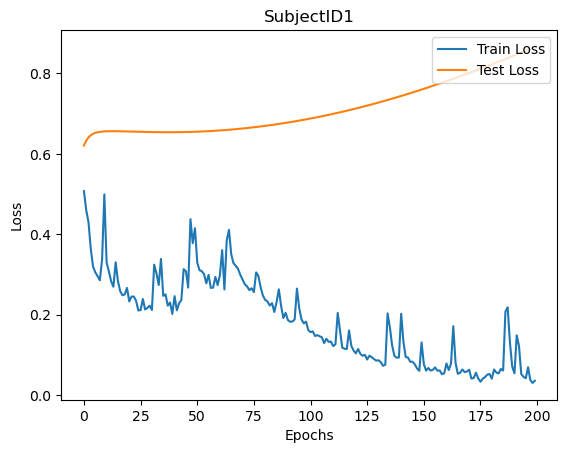

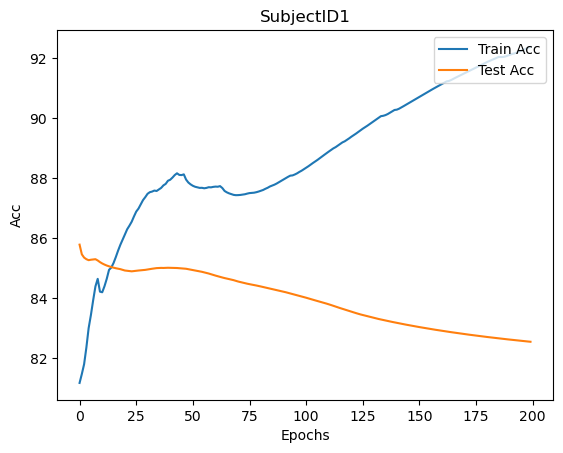

| epoch   0 | 0.0091 s/epoch | train loss 0.4593
| epoch   1 | 0.0090 s/epoch | train loss 0.3881
| epoch   2 | 0.0079 s/epoch | train loss 0.3745
| epoch   3 | 0.0087 s/epoch | train loss 0.3621
| epoch   4 | 0.0083 s/epoch | train loss 0.3563
| epoch   5 | 0.0081 s/epoch | train loss 0.3531
| epoch   6 | 0.0086 s/epoch | train loss 0.3472
| epoch   7 | 0.0096 s/epoch | train loss 0.3402
| epoch   8 | 0.0085 s/epoch | train loss 0.3372
| epoch   9 | 0.0085 s/epoch | train loss 0.3364
| epoch  10 | 0.0088 s/epoch | train loss 0.3301
| epoch  11 | 0.0075 s/epoch | train loss 0.3300
| epoch  12 | 0.0082 s/epoch | train loss 0.3242
| epoch  13 | 0.0083 s/epoch | train loss 0.3152
| epoch  14 | 0.0083 s/epoch | train loss 0.3169
| epoch  15 | 0.0082 s/epoch | train loss 0.3088
| epoch  16 | 0.0078 s/epoch | train loss 0.3047
| epoch  17 | 0.0082 s/epoch | train loss 0.3069
| epoch  18 | 0.0087 s/epoch | train loss 0.2953
| epoch  19 | 0.0085 s/epoch | train loss 0.2969
| epoch  20 | 0.0089

| epoch 168 | 0.0092 s/epoch | train loss 0.0281
| epoch 169 | 0.0103 s/epoch | train loss 0.0196
| epoch 170 | 0.0096 s/epoch | train loss 0.0274
| epoch 171 | 0.0097 s/epoch | train loss 0.0272
| epoch 172 | 0.0090 s/epoch | train loss 0.0662
| epoch 173 | 0.0096 s/epoch | train loss 0.0394
| epoch 174 | 0.0093 s/epoch | train loss 0.0571
| epoch 175 | 0.0094 s/epoch | train loss 0.0281
| epoch 176 | 0.0094 s/epoch | train loss 0.0157
| epoch 177 | 0.0096 s/epoch | train loss 0.0222
| epoch 178 | 0.0096 s/epoch | train loss 0.0238
| epoch 179 | 0.0094 s/epoch | train loss 0.0499
| epoch 180 | 0.0089 s/epoch | train loss 0.0328
| epoch 181 | 0.0097 s/epoch | train loss 0.0306
| epoch 182 | 0.0095 s/epoch | train loss 0.0288
| epoch 183 | 0.0095 s/epoch | train loss 0.0439
| epoch 184 | 0.0096 s/epoch | train loss 0.0314
| epoch 185 | 0.0098 s/epoch | train loss 0.0184
| epoch 186 | 0.0090 s/epoch | train loss 0.0244
| epoch 187 | 0.0101 s/epoch | train loss 0.0354
| epoch 188 | 0.0104

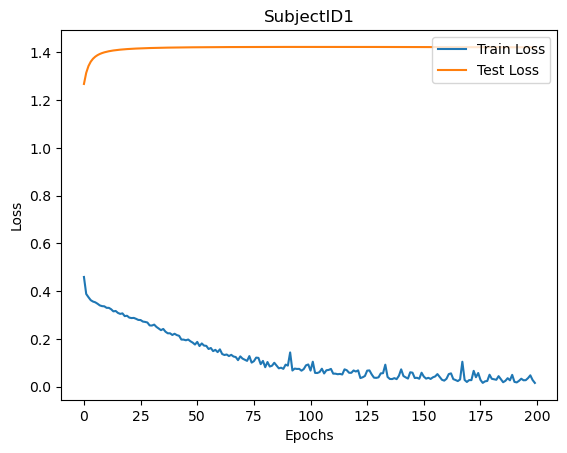

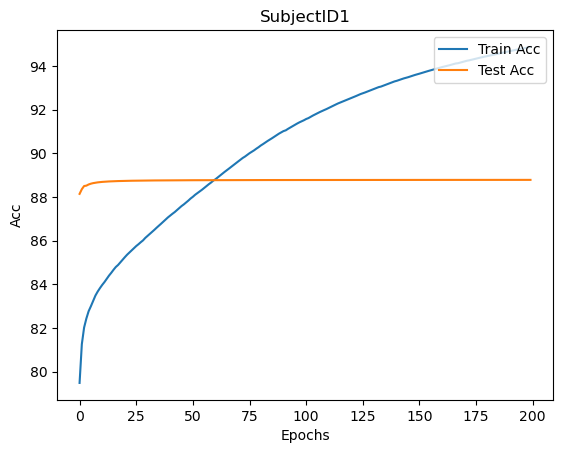


Subject 2
| epoch   0 | 0.3979 s/epoch | train loss 0.5059
| epoch   1 | 0.3760 s/epoch | train loss 0.5245
| epoch   2 | 0.3832 s/epoch | train loss 0.4374
| epoch   3 | 0.3704 s/epoch | train loss 0.3911
| epoch   4 | 0.3769 s/epoch | train loss 0.3782
| epoch   5 | 0.3771 s/epoch | train loss 0.3425
| epoch   6 | 0.3842 s/epoch | train loss 0.3119
| epoch   7 | 0.3909 s/epoch | train loss 0.2867
| epoch   8 | 0.3934 s/epoch | train loss 0.2793
| epoch   9 | 0.3810 s/epoch | train loss 0.3152
| epoch  10 | 0.3746 s/epoch | train loss 0.4385
| epoch  11 | 0.3719 s/epoch | train loss 0.4283
| epoch  12 | 0.3850 s/epoch | train loss 0.3550
| epoch  13 | 0.3829 s/epoch | train loss 0.3574
| epoch  14 | 0.3714 s/epoch | train loss 0.3218
| epoch  15 | 0.3827 s/epoch | train loss 0.2817
| epoch  16 | 0.3841 s/epoch | train loss 0.4301
| epoch  17 | 0.3747 s/epoch | train loss 0.4720
| epoch  18 | 0.3792 s/epoch | train loss 0.4989
| epoch  19 | 0.3836 s/epoch | train loss 0.5017
| epoch  

| epoch 167 | 0.3197 s/epoch | train loss 0.0904
| epoch 168 | 0.3210 s/epoch | train loss 0.0847
| epoch 169 | 0.3207 s/epoch | train loss 0.3412
| epoch 170 | 0.3215 s/epoch | train loss 0.2101
| epoch 171 | 0.3206 s/epoch | train loss 0.2026
| epoch 172 | 0.3211 s/epoch | train loss 0.1464
| epoch 173 | 0.3205 s/epoch | train loss 0.2195
| epoch 174 | 0.3220 s/epoch | train loss 0.2066
| epoch 175 | 0.3218 s/epoch | train loss 0.1395
| epoch 176 | 0.3201 s/epoch | train loss 0.3328
| epoch 177 | 0.3231 s/epoch | train loss 0.2642
| epoch 178 | 0.3255 s/epoch | train loss 0.2617
| epoch 179 | 0.3213 s/epoch | train loss 0.3761
| epoch 180 | 0.3219 s/epoch | train loss 0.2747
| epoch 181 | 0.3216 s/epoch | train loss 0.2800
| epoch 182 | 0.3244 s/epoch | train loss 0.2912
| epoch 183 | 0.3825 s/epoch | train loss 0.2284
| epoch 184 | 0.4248 s/epoch | train loss 0.1811
| epoch 185 | 0.3813 s/epoch | train loss 0.1617
| epoch 186 | 0.3809 s/epoch | train loss 0.3094
| epoch 187 | 0.3850

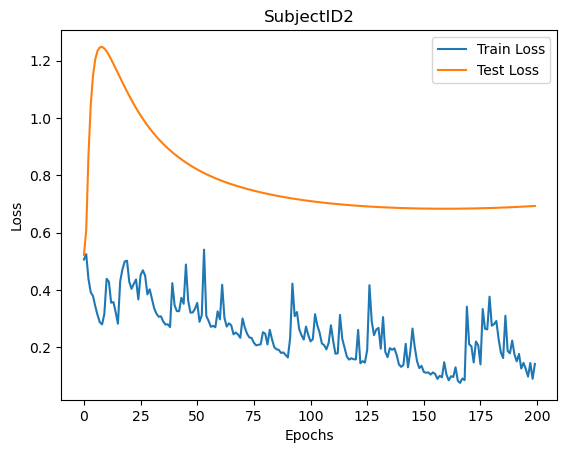

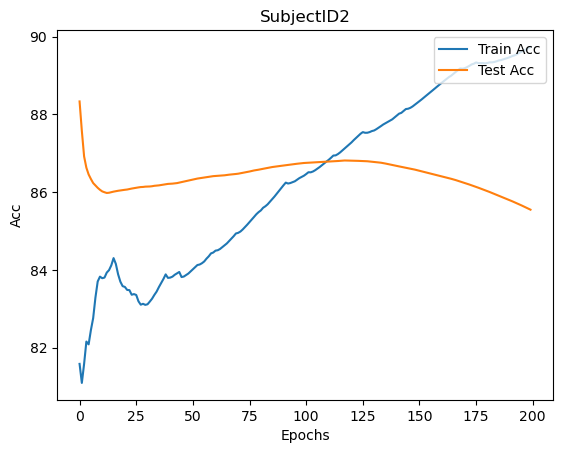

| epoch   0 | 0.0088 s/epoch | train loss 0.4516
| epoch   1 | 0.0100 s/epoch | train loss 0.3854
| epoch   2 | 0.0097 s/epoch | train loss 0.3783
| epoch   3 | 0.0100 s/epoch | train loss 0.3763
| epoch   4 | 0.0096 s/epoch | train loss 0.3657
| epoch   5 | 0.0097 s/epoch | train loss 0.3629
| epoch   6 | 0.0093 s/epoch | train loss 0.3653
| epoch   7 | 0.0097 s/epoch | train loss 0.3609
| epoch   8 | 0.0098 s/epoch | train loss 0.3531
| epoch   9 | 0.0106 s/epoch | train loss 0.3496
| epoch  10 | 0.0102 s/epoch | train loss 0.3390
| epoch  11 | 0.0098 s/epoch | train loss 0.3373
| epoch  12 | 0.0097 s/epoch | train loss 0.3321
| epoch  13 | 0.0095 s/epoch | train loss 0.3234
| epoch  14 | 0.0100 s/epoch | train loss 0.3219
| epoch  15 | 0.0091 s/epoch | train loss 0.3147
| epoch  16 | 0.0098 s/epoch | train loss 0.3119
| epoch  17 | 0.0093 s/epoch | train loss 0.3070
| epoch  18 | 0.0094 s/epoch | train loss 0.3100
| epoch  19 | 0.0102 s/epoch | train loss 0.3055
| epoch  20 | 0.0097

| epoch 168 | 0.0096 s/epoch | train loss 0.0527
| epoch 169 | 0.0093 s/epoch | train loss 0.0380
| epoch 170 | 0.0099 s/epoch | train loss 0.0192
| epoch 171 | 0.0102 s/epoch | train loss 0.0189
| epoch 172 | 0.0109 s/epoch | train loss 0.0434
| epoch 173 | 0.0107 s/epoch | train loss 0.0482
| epoch 174 | 0.0095 s/epoch | train loss 0.0440
| epoch 175 | 0.0100 s/epoch | train loss 0.0207
| epoch 176 | 0.0102 s/epoch | train loss 0.0165
| epoch 177 | 0.0099 s/epoch | train loss 0.0625
| epoch 178 | 0.0101 s/epoch | train loss 0.0340
| epoch 179 | 0.0099 s/epoch | train loss 0.0422
| epoch 180 | 0.0093 s/epoch | train loss 0.0257
| epoch 181 | 0.0097 s/epoch | train loss 0.0363
| epoch 182 | 0.0094 s/epoch | train loss 0.0367
| epoch 183 | 0.0099 s/epoch | train loss 0.0228
| epoch 184 | 0.0096 s/epoch | train loss 0.0216
| epoch 185 | 0.0091 s/epoch | train loss 0.0132
| epoch 186 | 0.0098 s/epoch | train loss 0.0115
| epoch 187 | 0.0089 s/epoch | train loss 0.0238
| epoch 188 | 0.0095

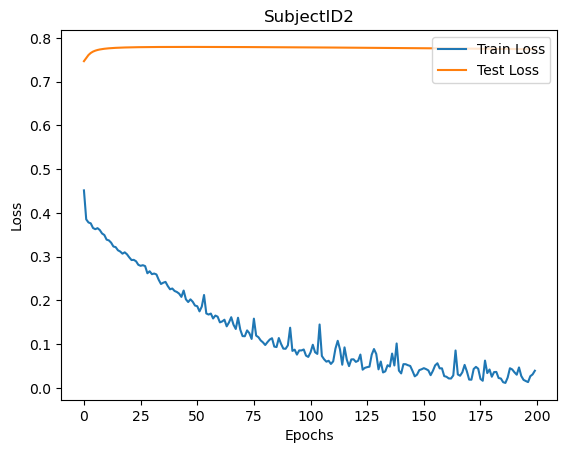

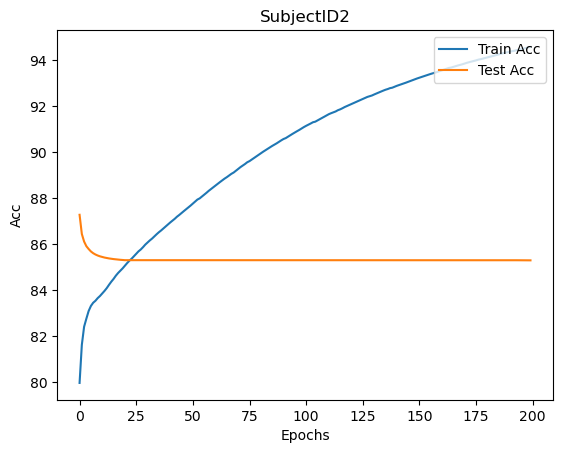


Subject 3
| epoch   0 | 0.3850 s/epoch | train loss 0.4823
| epoch   1 | 0.3851 s/epoch | train loss 0.4133
| epoch   2 | 0.3815 s/epoch | train loss 0.3914
| epoch   3 | 0.3882 s/epoch | train loss 0.3274
| epoch   4 | 0.3881 s/epoch | train loss 0.3037
| epoch   5 | 0.3747 s/epoch | train loss 0.2948
| epoch   6 | 0.3794 s/epoch | train loss 0.3147
| epoch   7 | 0.3849 s/epoch | train loss 0.3157
| epoch   8 | 0.3868 s/epoch | train loss 0.2874
| epoch   9 | 0.3739 s/epoch | train loss 0.2782
| epoch  10 | 0.3870 s/epoch | train loss 0.2566
| epoch  11 | 0.3252 s/epoch | train loss 0.2516
| epoch  12 | 0.3417 s/epoch | train loss 0.2629
| epoch  13 | 0.3223 s/epoch | train loss 0.2268
| epoch  14 | 0.3198 s/epoch | train loss 0.2259
| epoch  15 | 0.3210 s/epoch | train loss 0.2519
| epoch  16 | 0.3207 s/epoch | train loss 0.2121
| epoch  17 | 0.3254 s/epoch | train loss 0.1940
| epoch  18 | 0.3206 s/epoch | train loss 0.2036
| epoch  19 | 0.3196 s/epoch | train loss 0.1979
| epoch  

| epoch 167 | 0.3921 s/epoch | train loss 0.0855
| epoch 168 | 0.3922 s/epoch | train loss 0.0758
| epoch 169 | 0.3914 s/epoch | train loss 0.0827
| epoch 170 | 0.3907 s/epoch | train loss 0.0869
| epoch 171 | 0.3910 s/epoch | train loss 0.0703
| epoch 172 | 0.3912 s/epoch | train loss 0.0720
| epoch 173 | 0.3810 s/epoch | train loss 0.0657
| epoch 174 | 0.3838 s/epoch | train loss 0.0560
| epoch 175 | 0.3829 s/epoch | train loss 0.0678
| epoch 176 | 0.3855 s/epoch | train loss 0.0633
| epoch 177 | 0.3834 s/epoch | train loss 0.0774
| epoch 178 | 0.3846 s/epoch | train loss 0.0575
| epoch 179 | 0.3827 s/epoch | train loss 0.0579
| epoch 180 | 0.3784 s/epoch | train loss 0.0629
| epoch 181 | 0.3701 s/epoch | train loss 0.0660
| epoch 182 | 0.3795 s/epoch | train loss 0.0557
| epoch 183 | 0.3783 s/epoch | train loss 0.0511
| epoch 184 | 0.3754 s/epoch | train loss 0.0525
| epoch 185 | 0.3867 s/epoch | train loss 0.0564
| epoch 186 | 0.3803 s/epoch | train loss 0.0543
| epoch 187 | 0.3802

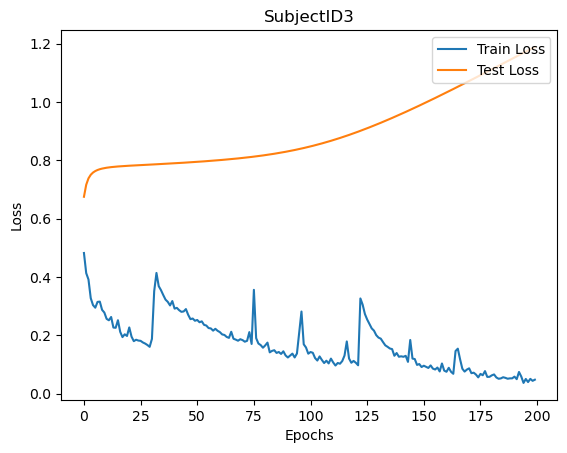

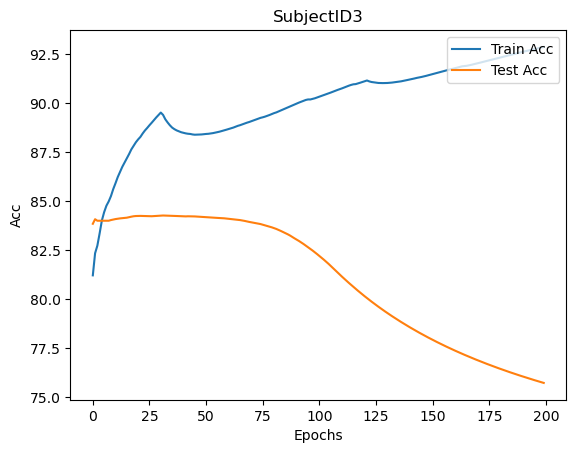

| epoch   0 | 0.0103 s/epoch | train loss 0.4426
| epoch   1 | 0.0107 s/epoch | train loss 0.3703
| epoch   2 | 0.0098 s/epoch | train loss 0.3580
| epoch   3 | 0.0112 s/epoch | train loss 0.3537
| epoch   4 | 0.0103 s/epoch | train loss 0.3471
| epoch   5 | 0.0105 s/epoch | train loss 0.3396
| epoch   6 | 0.0105 s/epoch | train loss 0.3415
| epoch   7 | 0.0114 s/epoch | train loss 0.3304
| epoch   8 | 0.0103 s/epoch | train loss 0.3216
| epoch   9 | 0.0112 s/epoch | train loss 0.3143
| epoch  10 | 0.0099 s/epoch | train loss 0.3098
| epoch  11 | 0.0103 s/epoch | train loss 0.3052
| epoch  12 | 0.0108 s/epoch | train loss 0.3021
| epoch  13 | 0.0107 s/epoch | train loss 0.3002
| epoch  14 | 0.0107 s/epoch | train loss 0.2933
| epoch  15 | 0.0103 s/epoch | train loss 0.2875
| epoch  16 | 0.0105 s/epoch | train loss 0.2803
| epoch  17 | 0.0111 s/epoch | train loss 0.2819
| epoch  18 | 0.0107 s/epoch | train loss 0.2818
| epoch  19 | 0.0112 s/epoch | train loss 0.2731
| epoch  20 | 0.0111

| epoch 168 | 0.0105 s/epoch | train loss 0.0445
| epoch 169 | 0.0105 s/epoch | train loss 0.0470
| epoch 170 | 0.0100 s/epoch | train loss 0.0220
| epoch 171 | 0.0102 s/epoch | train loss 0.0179
| epoch 172 | 0.0101 s/epoch | train loss 0.0160
| epoch 173 | 0.0093 s/epoch | train loss 0.0323
| epoch 174 | 0.0100 s/epoch | train loss 0.0384
| epoch 175 | 0.0097 s/epoch | train loss 0.0215
| epoch 176 | 0.0109 s/epoch | train loss 0.0191
| epoch 177 | 0.0096 s/epoch | train loss 0.0199
| epoch 178 | 0.0099 s/epoch | train loss 0.0234
| epoch 179 | 0.0107 s/epoch | train loss 0.0539
| epoch 180 | 0.0095 s/epoch | train loss 0.0289
| epoch 181 | 0.0097 s/epoch | train loss 0.0152
| epoch 182 | 0.0097 s/epoch | train loss 0.0191
| epoch 183 | 0.0099 s/epoch | train loss 0.0312
| epoch 184 | 0.0102 s/epoch | train loss 0.0316
| epoch 185 | 0.0098 s/epoch | train loss 0.0430
| epoch 186 | 0.0100 s/epoch | train loss 0.0212
| epoch 187 | 0.0104 s/epoch | train loss 0.0220
| epoch 188 | 0.0101

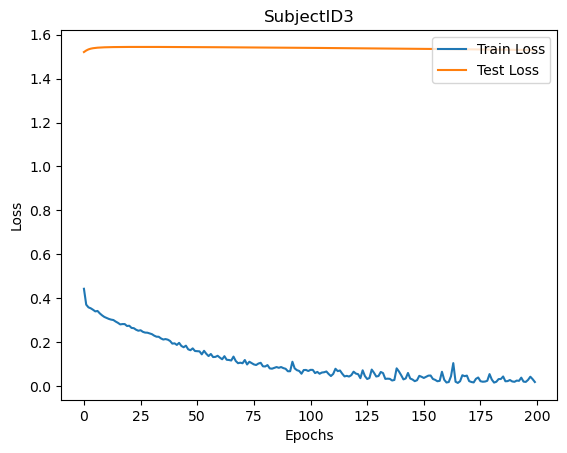

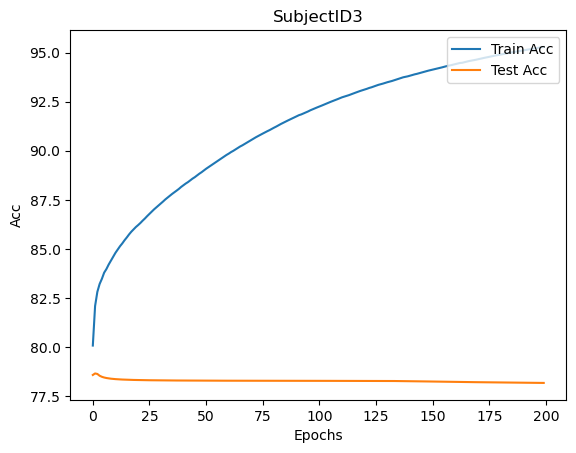


Subject 4
| epoch   0 | 0.4998 s/epoch | train loss 0.4431
| epoch   1 | 0.4833 s/epoch | train loss 0.3434
| epoch   2 | 0.4247 s/epoch | train loss 0.3168
| epoch   3 | 0.4344 s/epoch | train loss 0.3044
| epoch   4 | 0.4333 s/epoch | train loss 0.2831
| epoch   5 | 0.4349 s/epoch | train loss 0.2761
| epoch   6 | 0.4386 s/epoch | train loss 0.6042
| epoch   7 | 0.4312 s/epoch | train loss 0.3242
| epoch   8 | 0.4284 s/epoch | train loss 0.2856
| epoch   9 | 0.4385 s/epoch | train loss 0.2871
| epoch  10 | 0.4336 s/epoch | train loss 0.2798
| epoch  11 | 0.4257 s/epoch | train loss 0.2712
| epoch  12 | 0.4348 s/epoch | train loss 0.4876
| epoch  13 | 0.4359 s/epoch | train loss 0.3816
| epoch  14 | 0.4338 s/epoch | train loss 0.3334
| epoch  15 | 0.4338 s/epoch | train loss 0.3230
| epoch  16 | 0.4373 s/epoch | train loss 0.3128
| epoch  17 | 0.4394 s/epoch | train loss 0.2911
| epoch  18 | 0.4279 s/epoch | train loss 0.2730
| epoch  19 | 0.4293 s/epoch | train loss 0.2720
| epoch  

| epoch 167 | 0.4128 s/epoch | train loss 0.0980
| epoch 168 | 0.4180 s/epoch | train loss 0.1017
| epoch 169 | 0.4142 s/epoch | train loss 0.1019
| epoch 170 | 0.3989 s/epoch | train loss 0.1161
| epoch 171 | 0.4053 s/epoch | train loss 0.0960
| epoch 172 | 0.4095 s/epoch | train loss 0.0929
| epoch 173 | 0.4065 s/epoch | train loss 0.0949
| epoch 174 | 0.4108 s/epoch | train loss 0.0866
| epoch 175 | 0.3996 s/epoch | train loss 0.0939
| epoch 176 | 0.3882 s/epoch | train loss 0.0935
| epoch 177 | 0.4084 s/epoch | train loss 0.0849
| epoch 178 | 0.4096 s/epoch | train loss 0.0749
| epoch 179 | 0.4172 s/epoch | train loss 0.0903
| epoch 180 | 0.4122 s/epoch | train loss 0.0898
| epoch 181 | 0.4049 s/epoch | train loss 0.1466
| epoch 182 | 0.3919 s/epoch | train loss 0.1233
| epoch 183 | 0.3916 s/epoch | train loss 0.0965
| epoch 184 | 0.4087 s/epoch | train loss 0.0904
| epoch 185 | 0.4200 s/epoch | train loss 0.0867
| epoch 186 | 0.4211 s/epoch | train loss 0.0881
| epoch 187 | 0.4177

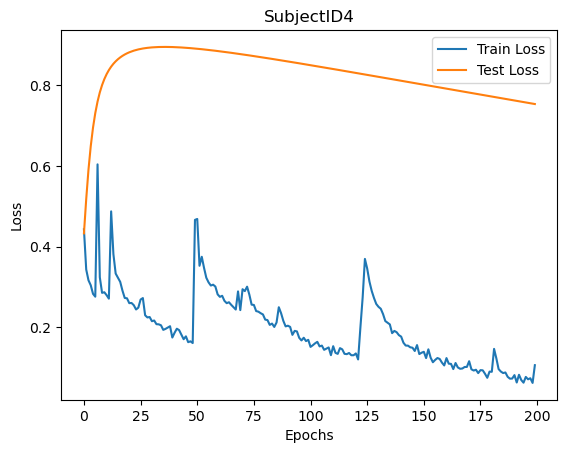

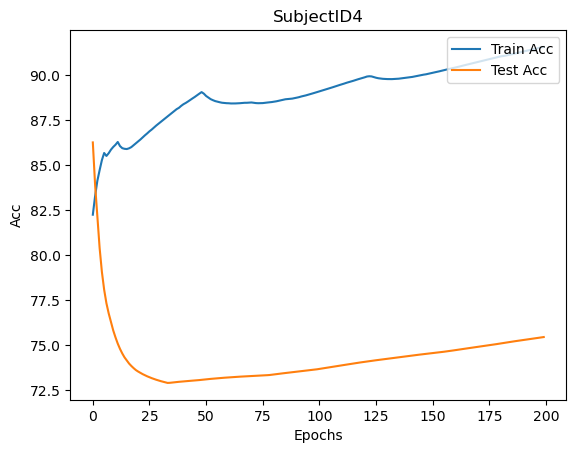

| epoch   0 | 0.0103 s/epoch | train loss 0.4474
| epoch   1 | 0.0099 s/epoch | train loss 0.3761
| epoch   2 | 0.0099 s/epoch | train loss 0.3630
| epoch   3 | 0.0101 s/epoch | train loss 0.3549
| epoch   4 | 0.0102 s/epoch | train loss 0.3460
| epoch   5 | 0.0096 s/epoch | train loss 0.3354
| epoch   6 | 0.0101 s/epoch | train loss 0.3291
| epoch   7 | 0.0099 s/epoch | train loss 0.3261
| epoch   8 | 0.0098 s/epoch | train loss 0.3197
| epoch   9 | 0.0097 s/epoch | train loss 0.3188
| epoch  10 | 0.0098 s/epoch | train loss 0.3136
| epoch  11 | 0.0097 s/epoch | train loss 0.3087
| epoch  12 | 0.0095 s/epoch | train loss 0.3005
| epoch  13 | 0.0097 s/epoch | train loss 0.2979
| epoch  14 | 0.0101 s/epoch | train loss 0.2945
| epoch  15 | 0.0102 s/epoch | train loss 0.2919
| epoch  16 | 0.0098 s/epoch | train loss 0.2875
| epoch  17 | 0.0101 s/epoch | train loss 0.2843
| epoch  18 | 0.0098 s/epoch | train loss 0.2771
| epoch  19 | 0.0098 s/epoch | train loss 0.2760
| epoch  20 | 0.0092

| epoch 168 | 0.0075 s/epoch | train loss 0.0281
| epoch 169 | 0.0076 s/epoch | train loss 0.0254
| epoch 170 | 0.0078 s/epoch | train loss 0.0310
| epoch 171 | 0.0073 s/epoch | train loss 0.0292
| epoch 172 | 0.0075 s/epoch | train loss 0.0171
| epoch 173 | 0.0076 s/epoch | train loss 0.0233
| epoch 174 | 0.0075 s/epoch | train loss 0.0310
| epoch 175 | 0.0079 s/epoch | train loss 0.0177
| epoch 176 | 0.0082 s/epoch | train loss 0.0242
| epoch 177 | 0.0077 s/epoch | train loss 0.0317
| epoch 178 | 0.0072 s/epoch | train loss 0.0321
| epoch 179 | 0.0083 s/epoch | train loss 0.0242
| epoch 180 | 0.0081 s/epoch | train loss 0.0395
| epoch 181 | 0.0080 s/epoch | train loss 0.0270
| epoch 182 | 0.0079 s/epoch | train loss 0.0239
| epoch 183 | 0.0073 s/epoch | train loss 0.0091
| epoch 184 | 0.0082 s/epoch | train loss 0.0121
| epoch 185 | 0.0076 s/epoch | train loss 0.0242
| epoch 186 | 0.0086 s/epoch | train loss 0.0242
| epoch 187 | 0.0075 s/epoch | train loss 0.0201
| epoch 188 | 0.0077

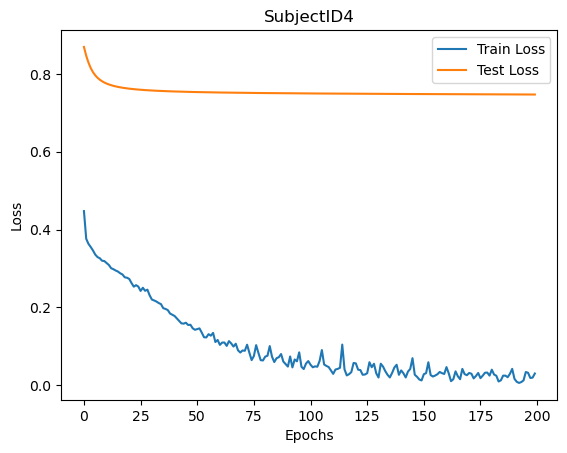

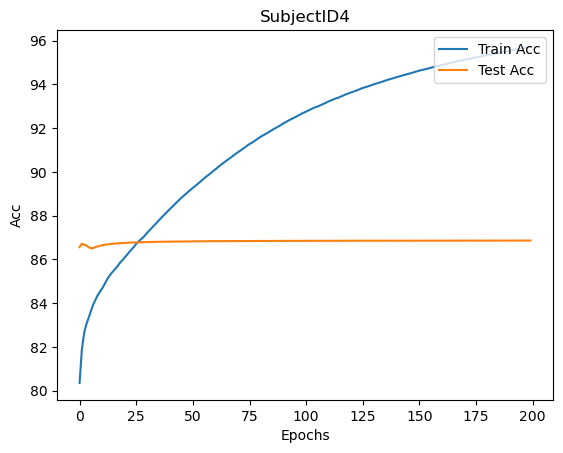


Subject 5
| epoch   0 | 0.3138 s/epoch | train loss 0.4867
| epoch   1 | 0.3130 s/epoch | train loss 0.3954
| epoch   2 | 0.3123 s/epoch | train loss 0.3659
| epoch   3 | 0.3138 s/epoch | train loss 0.3857
| epoch   4 | 0.3158 s/epoch | train loss 0.3358
| epoch   5 | 0.3155 s/epoch | train loss 0.4195
| epoch   6 | 0.3139 s/epoch | train loss 0.3664
| epoch   7 | 0.3132 s/epoch | train loss 0.3150
| epoch   8 | 0.3127 s/epoch | train loss 0.3279
| epoch   9 | 0.3136 s/epoch | train loss 0.3012
| epoch  10 | 0.3138 s/epoch | train loss 0.2751
| epoch  11 | 0.3158 s/epoch | train loss 0.2757
| epoch  12 | 0.3138 s/epoch | train loss 0.2572
| epoch  13 | 0.3148 s/epoch | train loss 0.2521
| epoch  14 | 0.3150 s/epoch | train loss 0.2378
| epoch  15 | 0.3145 s/epoch | train loss 0.2310
| epoch  16 | 0.3183 s/epoch | train loss 0.2279
| epoch  17 | 0.3162 s/epoch | train loss 0.2392
| epoch  18 | 0.3147 s/epoch | train loss 0.2184
| epoch  19 | 0.3143 s/epoch | train loss 0.2082
| epoch  

| epoch 167 | 0.3217 s/epoch | train loss 0.0590
| epoch 168 | 0.3213 s/epoch | train loss 0.0408
| epoch 169 | 0.3230 s/epoch | train loss 0.0491
| epoch 170 | 0.3229 s/epoch | train loss 0.0503
| epoch 171 | 0.3222 s/epoch | train loss 0.0376
| epoch 172 | 0.3186 s/epoch | train loss 0.0435
| epoch 173 | 0.3185 s/epoch | train loss 0.0397
| epoch 174 | 0.3178 s/epoch | train loss 0.0380
| epoch 175 | 0.3192 s/epoch | train loss 0.0418
| epoch 176 | 0.3156 s/epoch | train loss 0.0560
| epoch 177 | 0.3182 s/epoch | train loss 0.0454
| epoch 178 | 0.3176 s/epoch | train loss 0.0536
| epoch 179 | 0.3176 s/epoch | train loss 0.0442
| epoch 180 | 0.3172 s/epoch | train loss 0.0897
| epoch 181 | 0.3173 s/epoch | train loss 0.2377
| epoch 182 | 0.3175 s/epoch | train loss 0.1575
| epoch 183 | 0.3176 s/epoch | train loss 0.1056
| epoch 184 | 0.3166 s/epoch | train loss 0.0798
| epoch 185 | 0.3163 s/epoch | train loss 0.0603
| epoch 186 | 0.3153 s/epoch | train loss 0.0557
| epoch 187 | 0.3174

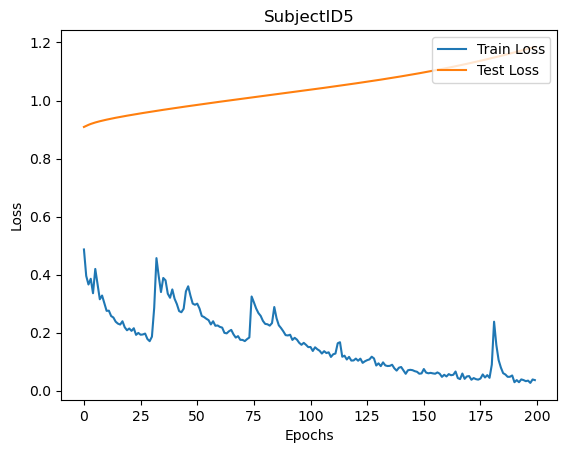

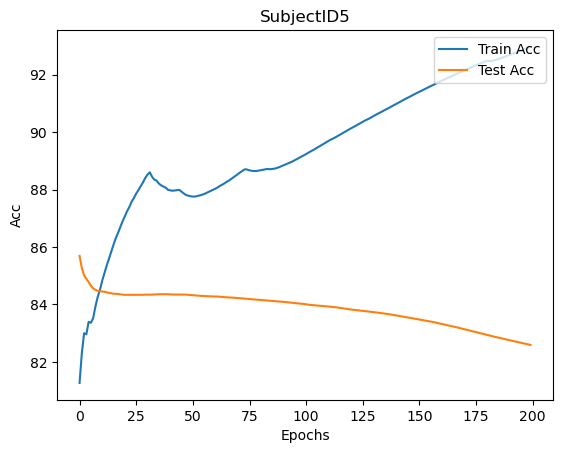

| epoch   0 | 0.0100 s/epoch | train loss 0.4628
| epoch   1 | 0.0105 s/epoch | train loss 0.3711
| epoch   2 | 0.0101 s/epoch | train loss 0.3604
| epoch   3 | 0.0103 s/epoch | train loss 0.3609
| epoch   4 | 0.0096 s/epoch | train loss 0.3494
| epoch   5 | 0.0099 s/epoch | train loss 0.3478
| epoch   6 | 0.0098 s/epoch | train loss 0.3413
| epoch   7 | 0.0111 s/epoch | train loss 0.3353
| epoch   8 | 0.0095 s/epoch | train loss 0.3325
| epoch   9 | 0.0093 s/epoch | train loss 0.3234
| epoch  10 | 0.0096 s/epoch | train loss 0.3227
| epoch  11 | 0.0106 s/epoch | train loss 0.3166
| epoch  12 | 0.0106 s/epoch | train loss 0.3167
| epoch  13 | 0.0105 s/epoch | train loss 0.3136
| epoch  14 | 0.0099 s/epoch | train loss 0.3064
| epoch  15 | 0.0104 s/epoch | train loss 0.3050
| epoch  16 | 0.0100 s/epoch | train loss 0.3010
| epoch  17 | 0.0096 s/epoch | train loss 0.2905
| epoch  18 | 0.0110 s/epoch | train loss 0.2880
| epoch  19 | 0.0106 s/epoch | train loss 0.2876
| epoch  20 | 0.0101

| epoch 168 | 0.0101 s/epoch | train loss 0.0201
| epoch 169 | 0.0100 s/epoch | train loss 0.0400
| epoch 170 | 0.0104 s/epoch | train loss 0.0302
| epoch 171 | 0.0101 s/epoch | train loss 0.0154
| epoch 172 | 0.0099 s/epoch | train loss 0.0135
| epoch 173 | 0.0100 s/epoch | train loss 0.0449
| epoch 174 | 0.0093 s/epoch | train loss 0.0290
| epoch 175 | 0.0095 s/epoch | train loss 0.0189
| epoch 176 | 0.0102 s/epoch | train loss 0.0274
| epoch 177 | 0.0099 s/epoch | train loss 0.0391
| epoch 178 | 0.0101 s/epoch | train loss 0.0302
| epoch 179 | 0.0092 s/epoch | train loss 0.0251
| epoch 180 | 0.0095 s/epoch | train loss 0.0189
| epoch 181 | 0.0102 s/epoch | train loss 0.0178
| epoch 182 | 0.0105 s/epoch | train loss 0.0195
| epoch 183 | 0.0104 s/epoch | train loss 0.0548
| epoch 184 | 0.0095 s/epoch | train loss 0.0383
| epoch 185 | 0.0107 s/epoch | train loss 0.0200
| epoch 186 | 0.0102 s/epoch | train loss 0.0111
| epoch 187 | 0.0105 s/epoch | train loss 0.0176
| epoch 188 | 0.0100

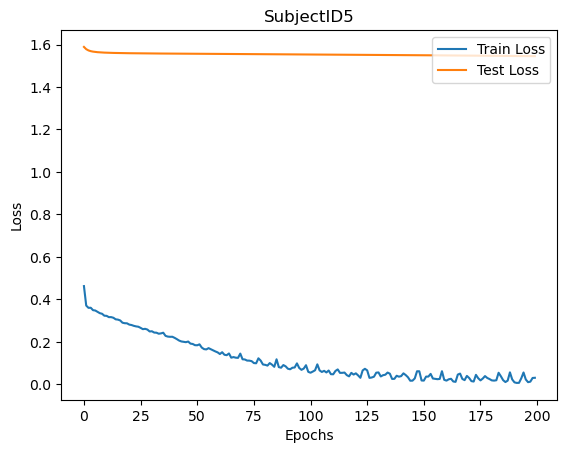

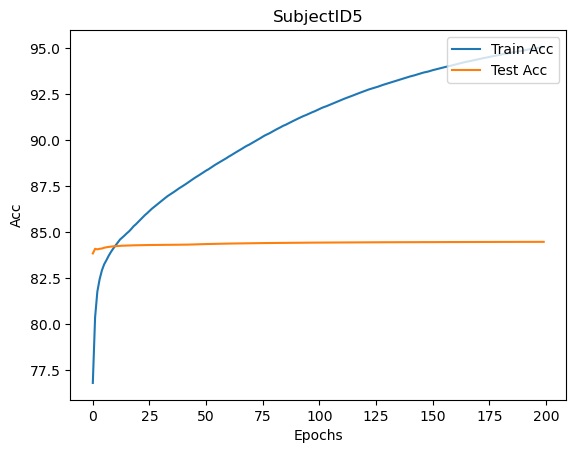


Subject 7
| epoch   0 | 0.3819 s/epoch | train loss 0.4856
| epoch   1 | 0.3789 s/epoch | train loss 0.3899
| epoch   2 | 0.3782 s/epoch | train loss 0.3291
| epoch   3 | 0.3958 s/epoch | train loss 0.3033
| epoch   4 | 0.3877 s/epoch | train loss 0.2829
| epoch   5 | 0.3850 s/epoch | train loss 0.2625
| epoch   6 | 0.3875 s/epoch | train loss 0.2605
| epoch   7 | 0.3902 s/epoch | train loss 0.2454
| epoch   8 | 0.3903 s/epoch | train loss 0.2329
| epoch   9 | 0.3829 s/epoch | train loss 0.2349
| epoch  10 | 0.3947 s/epoch | train loss 0.2181
| epoch  11 | 0.3920 s/epoch | train loss 0.2206
| epoch  12 | 0.3929 s/epoch | train loss 0.2041
| epoch  13 | 0.3941 s/epoch | train loss 0.2984
| epoch  14 | 0.3915 s/epoch | train loss 0.3999
| epoch  15 | 0.3946 s/epoch | train loss 0.3246
| epoch  16 | 0.3870 s/epoch | train loss 0.3014
| epoch  17 | 0.3814 s/epoch | train loss 0.3067
| epoch  18 | 0.3962 s/epoch | train loss 0.3070
| epoch  19 | 0.3884 s/epoch | train loss 0.2717
| epoch  

| epoch 167 | 0.3052 s/epoch | train loss 0.0521
| epoch 168 | 0.3059 s/epoch | train loss 0.0508
| epoch 169 | 0.3041 s/epoch | train loss 0.0555
| epoch 170 | 0.3047 s/epoch | train loss 0.0451
| epoch 171 | 0.3027 s/epoch | train loss 0.0497
| epoch 172 | 0.3050 s/epoch | train loss 0.0395
| epoch 173 | 0.3083 s/epoch | train loss 0.0460
| epoch 174 | 0.3043 s/epoch | train loss 0.0543
| epoch 175 | 0.3042 s/epoch | train loss 0.0402
| epoch 176 | 0.3074 s/epoch | train loss 0.0423
| epoch 177 | 0.3067 s/epoch | train loss 0.0438
| epoch 178 | 0.3110 s/epoch | train loss 0.0348
| epoch 179 | 0.3082 s/epoch | train loss 0.0345
| epoch 180 | 0.3129 s/epoch | train loss 0.0256
| epoch 181 | 0.3136 s/epoch | train loss 0.0640
| epoch 182 | 0.3107 s/epoch | train loss 0.0401
| epoch 183 | 0.3121 s/epoch | train loss 0.0482
| epoch 184 | 0.3103 s/epoch | train loss 0.0355
| epoch 185 | 0.3106 s/epoch | train loss 0.0381
| epoch 186 | 0.3108 s/epoch | train loss 0.0377
| epoch 187 | 0.3110

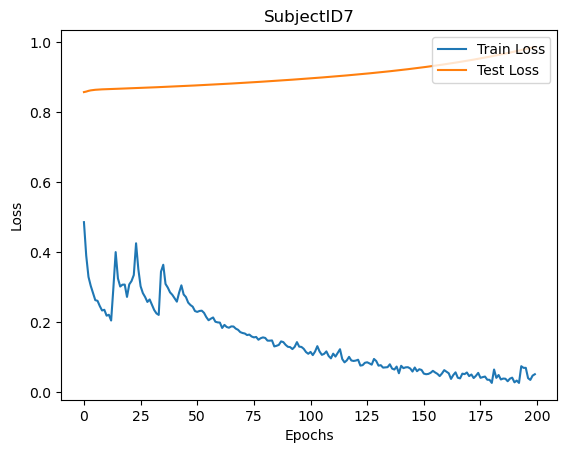

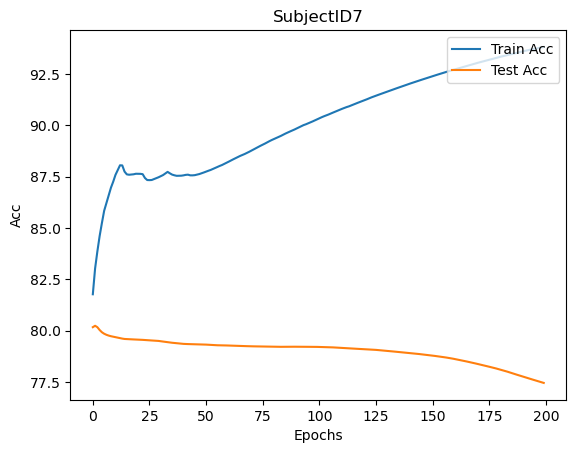

| epoch   0 | 0.0069 s/epoch | train loss 0.4815
| epoch   1 | 0.0076 s/epoch | train loss 0.3590
| epoch   2 | 0.0072 s/epoch | train loss 0.3436
| epoch   3 | 0.0069 s/epoch | train loss 0.3387
| epoch   4 | 0.0075 s/epoch | train loss 0.3305
| epoch   5 | 0.0072 s/epoch | train loss 0.3283
| epoch   6 | 0.0075 s/epoch | train loss 0.3271
| epoch   7 | 0.0069 s/epoch | train loss 0.3168
| epoch   8 | 0.0068 s/epoch | train loss 0.3118
| epoch   9 | 0.0077 s/epoch | train loss 0.3121
| epoch  10 | 0.0069 s/epoch | train loss 0.2994
| epoch  11 | 0.0073 s/epoch | train loss 0.2939
| epoch  12 | 0.0074 s/epoch | train loss 0.3025
| epoch  13 | 0.0075 s/epoch | train loss 0.2923
| epoch  14 | 0.0069 s/epoch | train loss 0.2906
| epoch  15 | 0.0074 s/epoch | train loss 0.2835
| epoch  16 | 0.0076 s/epoch | train loss 0.2882
| epoch  17 | 0.0073 s/epoch | train loss 0.2789
| epoch  18 | 0.0073 s/epoch | train loss 0.2763
| epoch  19 | 0.0070 s/epoch | train loss 0.2696
| epoch  20 | 0.0072

| epoch 168 | 0.0069 s/epoch | train loss 0.0140
| epoch 169 | 0.0072 s/epoch | train loss 0.0714
| epoch 170 | 0.0066 s/epoch | train loss 0.0279
| epoch 171 | 0.0078 s/epoch | train loss 0.0177
| epoch 172 | 0.0072 s/epoch | train loss 0.0123
| epoch 173 | 0.0077 s/epoch | train loss 0.0188
| epoch 174 | 0.0077 s/epoch | train loss 0.0439
| epoch 175 | 0.0071 s/epoch | train loss 0.0210
| epoch 176 | 0.0075 s/epoch | train loss 0.0272
| epoch 177 | 0.0071 s/epoch | train loss 0.0437
| epoch 178 | 0.0076 s/epoch | train loss 0.0252
| epoch 179 | 0.0075 s/epoch | train loss 0.0153
| epoch 180 | 0.0076 s/epoch | train loss 0.0101
| epoch 181 | 0.0077 s/epoch | train loss 0.0199
| epoch 182 | 0.0076 s/epoch | train loss 0.0317
| epoch 183 | 0.0071 s/epoch | train loss 0.0191
| epoch 184 | 0.0072 s/epoch | train loss 0.0142
| epoch 185 | 0.0070 s/epoch | train loss 0.0330
| epoch 186 | 0.0077 s/epoch | train loss 0.0258
| epoch 187 | 0.0079 s/epoch | train loss 0.0214
| epoch 188 | 0.0079

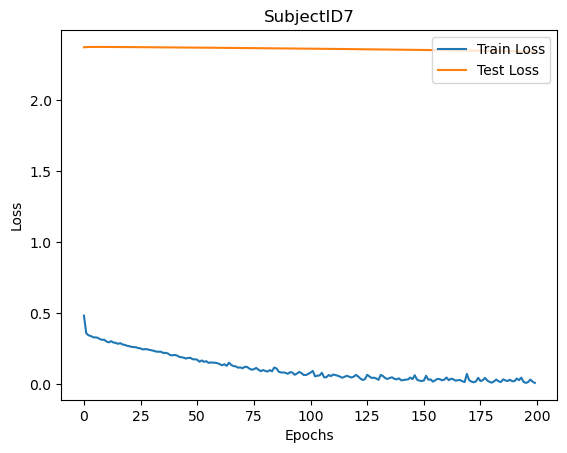

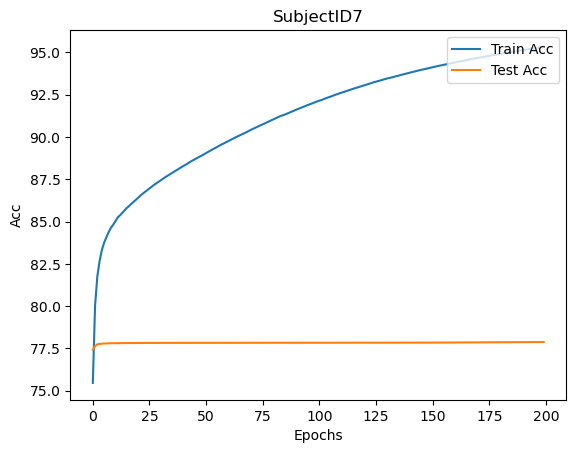


Subject 8
| epoch   0 | 0.3284 s/epoch | train loss 0.5321
| epoch   1 | 0.3268 s/epoch | train loss 0.3483
| epoch   2 | 0.3257 s/epoch | train loss 0.3137
| epoch   3 | 0.3243 s/epoch | train loss 0.3233
| epoch   4 | 0.3272 s/epoch | train loss 0.2906
| epoch   5 | 0.3268 s/epoch | train loss 0.2658
| epoch   6 | 0.3257 s/epoch | train loss 0.2634
| epoch   7 | 0.3261 s/epoch | train loss 0.2538
| epoch   8 | 0.3242 s/epoch | train loss 0.2361
| epoch   9 | 0.3258 s/epoch | train loss 0.2548
| epoch  10 | 0.3278 s/epoch | train loss 0.2324
| epoch  11 | 0.3255 s/epoch | train loss 0.2232
| epoch  12 | 0.3274 s/epoch | train loss 0.2304
| epoch  13 | 0.3278 s/epoch | train loss 0.2107
| epoch  14 | 0.3274 s/epoch | train loss 0.2084
| epoch  15 | 0.3248 s/epoch | train loss 0.2025
| epoch  16 | 0.3270 s/epoch | train loss 0.2083
| epoch  17 | 0.3276 s/epoch | train loss 0.2042
| epoch  18 | 0.3262 s/epoch | train loss 0.2005
| epoch  19 | 0.3267 s/epoch | train loss 0.1794
| epoch  

| epoch 167 | 0.3304 s/epoch | train loss 0.0568
| epoch 168 | 0.3895 s/epoch | train loss 0.0534
| epoch 169 | 0.4075 s/epoch | train loss 0.1036
| epoch 170 | 0.4122 s/epoch | train loss 0.0566
| epoch 171 | 0.4065 s/epoch | train loss 0.0471
| epoch 172 | 0.4117 s/epoch | train loss 0.0384
| epoch 173 | 0.4093 s/epoch | train loss 0.0521
| epoch 174 | 0.4111 s/epoch | train loss 0.0637
| epoch 175 | 0.4125 s/epoch | train loss 0.0437
| epoch 176 | 0.4088 s/epoch | train loss 0.0358
| epoch 177 | 0.4100 s/epoch | train loss 0.0750
| epoch 178 | 0.4165 s/epoch | train loss 0.0372
| epoch 179 | 0.4168 s/epoch | train loss 0.0322
| epoch 180 | 0.4123 s/epoch | train loss 0.0398
| epoch 181 | 0.4136 s/epoch | train loss 0.0359
| epoch 182 | 0.4145 s/epoch | train loss 0.0329
| epoch 183 | 0.3577 s/epoch | train loss 0.0329
| epoch 184 | 0.3327 s/epoch | train loss 0.0466
| epoch 185 | 0.3319 s/epoch | train loss 0.0323
| epoch 186 | 0.3325 s/epoch | train loss 0.0351
| epoch 187 | 0.3316

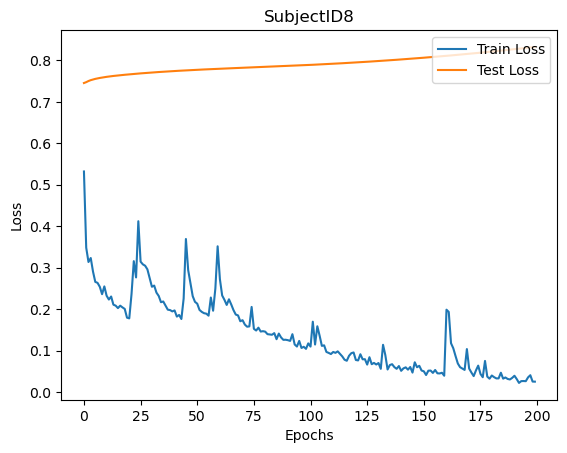

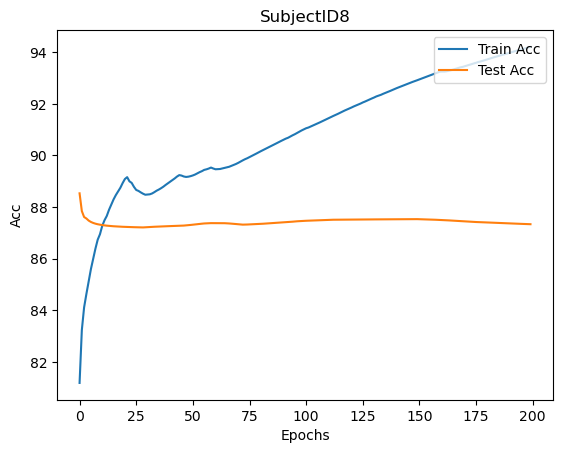

| epoch   0 | 0.0081 s/epoch | train loss 0.4634
| epoch   1 | 0.0086 s/epoch | train loss 0.3938
| epoch   2 | 0.0088 s/epoch | train loss 0.3747
| epoch   3 | 0.0077 s/epoch | train loss 0.3671
| epoch   4 | 0.0076 s/epoch | train loss 0.3583
| epoch   5 | 0.0072 s/epoch | train loss 0.3515
| epoch   6 | 0.0077 s/epoch | train loss 0.3430
| epoch   7 | 0.0080 s/epoch | train loss 0.3373
| epoch   8 | 0.0078 s/epoch | train loss 0.3332
| epoch   9 | 0.0087 s/epoch | train loss 0.3241
| epoch  10 | 0.0079 s/epoch | train loss 0.3194
| epoch  11 | 0.0078 s/epoch | train loss 0.3134
| epoch  12 | 0.0075 s/epoch | train loss 0.3090
| epoch  13 | 0.0081 s/epoch | train loss 0.3068
| epoch  14 | 0.0076 s/epoch | train loss 0.2968
| epoch  15 | 0.0084 s/epoch | train loss 0.2948
| epoch  16 | 0.0076 s/epoch | train loss 0.2906
| epoch  17 | 0.0075 s/epoch | train loss 0.2849
| epoch  18 | 0.0077 s/epoch | train loss 0.2777
| epoch  19 | 0.0079 s/epoch | train loss 0.2804
| epoch  20 | 0.0077

| epoch 168 | 0.0082 s/epoch | train loss 0.0231
| epoch 169 | 0.0075 s/epoch | train loss 0.0522
| epoch 170 | 0.0080 s/epoch | train loss 0.0376
| epoch 171 | 0.0080 s/epoch | train loss 0.0167
| epoch 172 | 0.0076 s/epoch | train loss 0.0250
| epoch 173 | 0.0082 s/epoch | train loss 0.0334
| epoch 174 | 0.0086 s/epoch | train loss 0.0417
| epoch 175 | 0.0079 s/epoch | train loss 0.0313
| epoch 176 | 0.0073 s/epoch | train loss 0.0196
| epoch 177 | 0.0079 s/epoch | train loss 0.0298
| epoch 178 | 0.0076 s/epoch | train loss 0.0273
| epoch 179 | 0.0071 s/epoch | train loss 0.0538
| epoch 180 | 0.0076 s/epoch | train loss 0.0482
| epoch 181 | 0.0080 s/epoch | train loss 0.0159
| epoch 182 | 0.0079 s/epoch | train loss 0.0097
| epoch 183 | 0.0080 s/epoch | train loss 0.0194
| epoch 184 | 0.0076 s/epoch | train loss 0.0281
| epoch 185 | 0.0079 s/epoch | train loss 0.0283
| epoch 186 | 0.0079 s/epoch | train loss 0.0241
| epoch 187 | 0.0083 s/epoch | train loss 0.0169
| epoch 188 | 0.0080

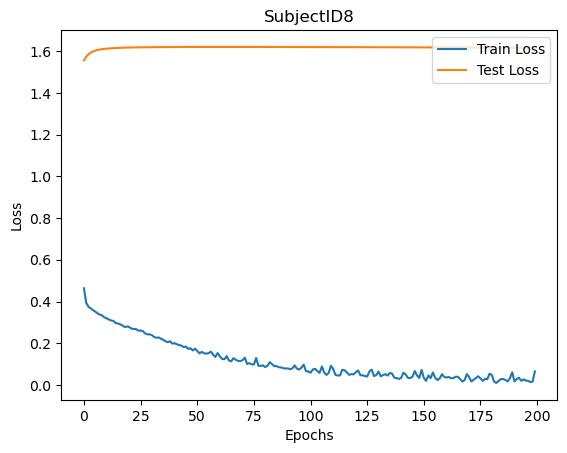

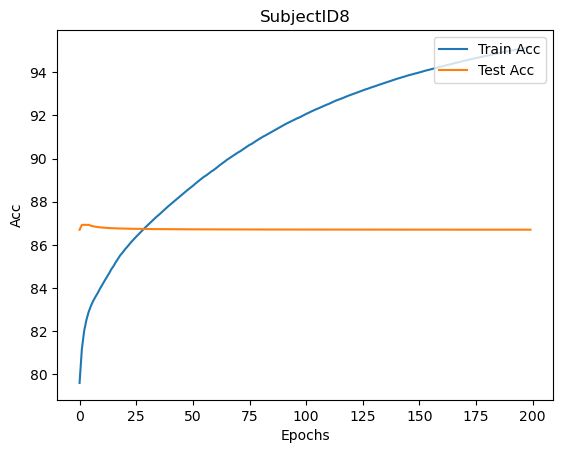


Subject 9
| epoch   0 | 0.3250 s/epoch | train loss 0.5020
| epoch   1 | 0.3257 s/epoch | train loss 0.3487
| epoch   2 | 0.3245 s/epoch | train loss 0.3227
| epoch   3 | 0.3259 s/epoch | train loss 0.2979
| epoch   4 | 0.3267 s/epoch | train loss 0.2840
| epoch   5 | 0.3258 s/epoch | train loss 0.2764
| epoch   6 | 0.3248 s/epoch | train loss 0.2694
| epoch   7 | 0.3258 s/epoch | train loss 0.2573
| epoch   8 | 0.3276 s/epoch | train loss 0.2470
| epoch   9 | 0.3273 s/epoch | train loss 0.2293
| epoch  10 | 0.3262 s/epoch | train loss 0.2339
| epoch  11 | 0.3247 s/epoch | train loss 0.2227
| epoch  12 | 0.3390 s/epoch | train loss 0.2223
| epoch  13 | 0.3414 s/epoch | train loss 0.2238
| epoch  14 | 0.3414 s/epoch | train loss 0.2154
| epoch  15 | 0.3422 s/epoch | train loss 0.2107
| epoch  16 | 0.3419 s/epoch | train loss 0.2077
| epoch  17 | 0.3384 s/epoch | train loss 0.2058
| epoch  18 | 0.3412 s/epoch | train loss 0.1894
| epoch  19 | 0.3403 s/epoch | train loss 0.1966
| epoch  

| epoch 167 | 0.4169 s/epoch | train loss 0.0615
| epoch 168 | 0.4094 s/epoch | train loss 0.0626
| epoch 169 | 0.4094 s/epoch | train loss 0.0591
| epoch 170 | 0.4068 s/epoch | train loss 0.0441
| epoch 171 | 0.4036 s/epoch | train loss 0.0619
| epoch 172 | 0.4102 s/epoch | train loss 0.0723
| epoch 173 | 0.4094 s/epoch | train loss 0.0611
| epoch 174 | 0.4143 s/epoch | train loss 0.0526
| epoch 175 | 0.4056 s/epoch | train loss 0.0576
| epoch 176 | 0.4135 s/epoch | train loss 0.0647
| epoch 177 | 0.4107 s/epoch | train loss 0.0457
| epoch 178 | 0.4123 s/epoch | train loss 0.0601
| epoch 179 | 0.4192 s/epoch | train loss 0.0626
| epoch 180 | 0.4089 s/epoch | train loss 0.0466
| epoch 181 | 0.4111 s/epoch | train loss 0.0516
| epoch 182 | 0.4098 s/epoch | train loss 0.0547
| epoch 183 | 0.4106 s/epoch | train loss 0.0514
| epoch 184 | 0.4125 s/epoch | train loss 0.0538
| epoch 185 | 0.4125 s/epoch | train loss 0.0469
| epoch 186 | 0.4139 s/epoch | train loss 0.0711
| epoch 187 | 0.3966

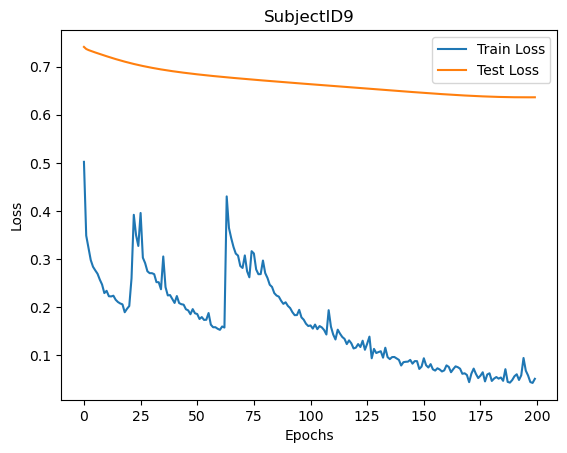

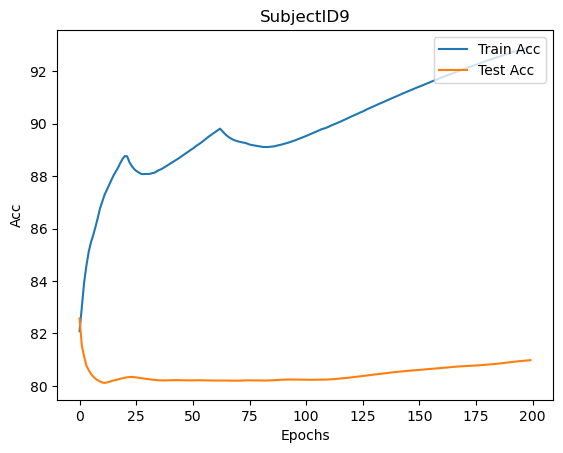

| epoch   0 | 0.0099 s/epoch | train loss 0.4555
| epoch   1 | 0.0099 s/epoch | train loss 0.3684
| epoch   2 | 0.0101 s/epoch | train loss 0.3650
| epoch   3 | 0.0104 s/epoch | train loss 0.3446
| epoch   4 | 0.0095 s/epoch | train loss 0.3446
| epoch   5 | 0.0094 s/epoch | train loss 0.3348
| epoch   6 | 0.0097 s/epoch | train loss 0.3331
| epoch   7 | 0.0095 s/epoch | train loss 0.3252
| epoch   8 | 0.0093 s/epoch | train loss 0.3286
| epoch   9 | 0.0096 s/epoch | train loss 0.3142
| epoch  10 | 0.0102 s/epoch | train loss 0.3098
| epoch  11 | 0.0104 s/epoch | train loss 0.3050
| epoch  12 | 0.0096 s/epoch | train loss 0.2982
| epoch  13 | 0.0097 s/epoch | train loss 0.2942
| epoch  14 | 0.0095 s/epoch | train loss 0.2926
| epoch  15 | 0.0102 s/epoch | train loss 0.2905
| epoch  16 | 0.0098 s/epoch | train loss 0.2823
| epoch  17 | 0.0099 s/epoch | train loss 0.2791
| epoch  18 | 0.0097 s/epoch | train loss 0.2756
| epoch  19 | 0.0100 s/epoch | train loss 0.2703
| epoch  20 | 0.0098

| epoch 168 | 0.0105 s/epoch | train loss 0.0421
| epoch 169 | 0.0096 s/epoch | train loss 0.0147
| epoch 170 | 0.0105 s/epoch | train loss 0.0264
| epoch 171 | 0.0100 s/epoch | train loss 0.0332
| epoch 172 | 0.0095 s/epoch | train loss 0.0160
| epoch 173 | 0.0096 s/epoch | train loss 0.0134
| epoch 174 | 0.0097 s/epoch | train loss 0.0296
| epoch 175 | 0.0091 s/epoch | train loss 0.0356
| epoch 176 | 0.0099 s/epoch | train loss 0.0191
| epoch 177 | 0.0095 s/epoch | train loss 0.0190
| epoch 178 | 0.0104 s/epoch | train loss 0.0297
| epoch 179 | 0.0100 s/epoch | train loss 0.0324
| epoch 180 | 0.0094 s/epoch | train loss 0.0121
| epoch 181 | 0.0100 s/epoch | train loss 0.0087
| epoch 182 | 0.0102 s/epoch | train loss 0.0113
| epoch 183 | 0.0098 s/epoch | train loss 0.0101
| epoch 184 | 0.0095 s/epoch | train loss 0.0402
| epoch 185 | 0.0100 s/epoch | train loss 0.0423
| epoch 186 | 0.0098 s/epoch | train loss 0.0168
| epoch 187 | 0.0100 s/epoch | train loss 0.0076
| epoch 188 | 0.0102

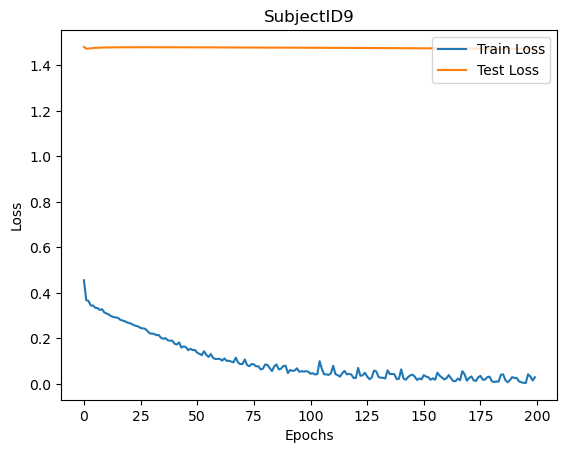

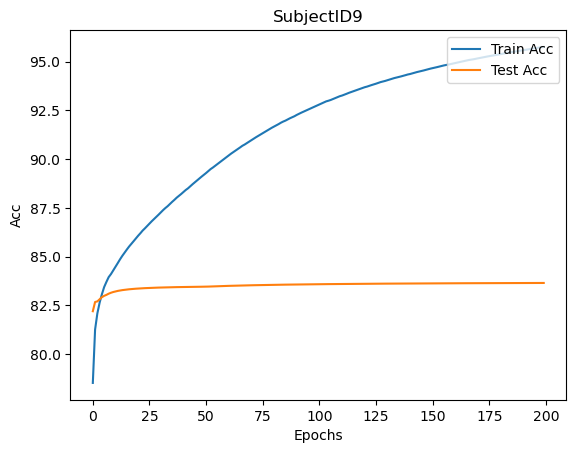


Subject 10
| epoch   0 | 0.4265 s/epoch | train loss 0.5041
| epoch   1 | 0.4206 s/epoch | train loss 0.3993
| epoch   2 | 0.4308 s/epoch | train loss 0.3550
| epoch   3 | 0.4230 s/epoch | train loss 0.3204
| epoch   4 | 0.4189 s/epoch | train loss 0.3635
| epoch   5 | 0.4218 s/epoch | train loss 0.3275
| epoch   6 | 0.4254 s/epoch | train loss 0.4636
| epoch   7 | 0.4168 s/epoch | train loss 0.4210
| epoch   8 | 0.4176 s/epoch | train loss 0.3672
| epoch   9 | 0.4238 s/epoch | train loss 0.3052
| epoch  10 | 0.4212 s/epoch | train loss 0.3043
| epoch  11 | 0.4155 s/epoch | train loss 0.3079
| epoch  12 | 0.4198 s/epoch | train loss 0.2907
| epoch  13 | 0.4164 s/epoch | train loss 0.2888
| epoch  14 | 0.4250 s/epoch | train loss 0.2990
| epoch  15 | 0.4173 s/epoch | train loss 0.2702
| epoch  16 | 0.4201 s/epoch | train loss 0.4075
| epoch  17 | 0.4173 s/epoch | train loss 0.4661
| epoch  18 | 0.4226 s/epoch | train loss 0.5718
| epoch  19 | 0.4220 s/epoch | train loss 0.4351
| epoch 

| epoch 167 | 0.3354 s/epoch | train loss 0.1247
| epoch 168 | 0.3354 s/epoch | train loss 0.1137
| epoch 169 | 0.3359 s/epoch | train loss 0.1178
| epoch 170 | 0.3372 s/epoch | train loss 0.1134
| epoch 171 | 0.3369 s/epoch | train loss 0.1051
| epoch 172 | 0.3379 s/epoch | train loss 0.1126
| epoch 173 | 0.3359 s/epoch | train loss 0.1131
| epoch 174 | 0.3351 s/epoch | train loss 0.1082
| epoch 175 | 0.3351 s/epoch | train loss 0.0962
| epoch 176 | 0.3362 s/epoch | train loss 0.1151
| epoch 177 | 0.3366 s/epoch | train loss 0.2065
| epoch 178 | 0.3361 s/epoch | train loss 0.1403
| epoch 179 | 0.3357 s/epoch | train loss 0.1262
| epoch 180 | 0.3367 s/epoch | train loss 0.1223
| epoch 181 | 0.3361 s/epoch | train loss 0.1159
| epoch 182 | 0.3351 s/epoch | train loss 0.1013
| epoch 183 | 0.3367 s/epoch | train loss 0.0856
| epoch 184 | 0.3356 s/epoch | train loss 0.0950
| epoch 185 | 0.3359 s/epoch | train loss 0.0904
| epoch 186 | 0.3357 s/epoch | train loss 0.0804
| epoch 187 | 0.3355

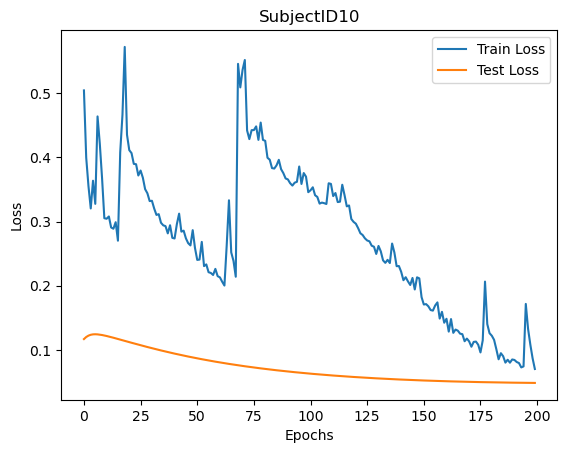

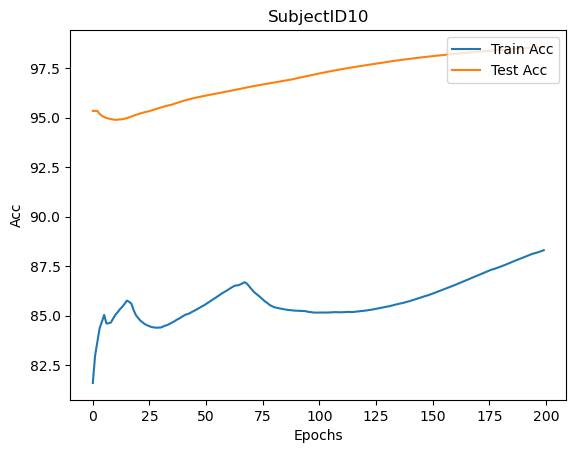

| epoch   0 | 0.0076 s/epoch | train loss 0.4608
| epoch   1 | 0.0083 s/epoch | train loss 0.3950
| epoch   2 | 0.0078 s/epoch | train loss 0.3785
| epoch   3 | 0.0073 s/epoch | train loss 0.3751
| epoch   4 | 0.0074 s/epoch | train loss 0.3633
| epoch   5 | 0.0081 s/epoch | train loss 0.3550
| epoch   6 | 0.0080 s/epoch | train loss 0.3510
| epoch   7 | 0.0081 s/epoch | train loss 0.3403
| epoch   8 | 0.0082 s/epoch | train loss 0.3433
| epoch   9 | 0.0079 s/epoch | train loss 0.3355
| epoch  10 | 0.0082 s/epoch | train loss 0.3379
| epoch  11 | 0.0080 s/epoch | train loss 0.3353
| epoch  12 | 0.0078 s/epoch | train loss 0.3256
| epoch  13 | 0.0077 s/epoch | train loss 0.3227
| epoch  14 | 0.0080 s/epoch | train loss 0.3200
| epoch  15 | 0.0092 s/epoch | train loss 0.3139
| epoch  16 | 0.0080 s/epoch | train loss 0.3111
| epoch  17 | 0.0078 s/epoch | train loss 0.3109
| epoch  18 | 0.0078 s/epoch | train loss 0.3073
| epoch  19 | 0.0079 s/epoch | train loss 0.2995
| epoch  20 | 0.0076

| epoch 168 | 0.0089 s/epoch | train loss 0.0208
| epoch 169 | 0.0081 s/epoch | train loss 0.0224
| epoch 170 | 0.0085 s/epoch | train loss 0.0238
| epoch 171 | 0.0079 s/epoch | train loss 0.0289
| epoch 172 | 0.0074 s/epoch | train loss 0.0288
| epoch 173 | 0.0077 s/epoch | train loss 0.0109
| epoch 174 | 0.0083 s/epoch | train loss 0.0240
| epoch 175 | 0.0074 s/epoch | train loss 0.0360
| epoch 176 | 0.0076 s/epoch | train loss 0.0202
| epoch 177 | 0.0080 s/epoch | train loss 0.0598
| epoch 178 | 0.0078 s/epoch | train loss 0.0279
| epoch 179 | 0.0074 s/epoch | train loss 0.0108
| epoch 180 | 0.0079 s/epoch | train loss 0.0168
| epoch 181 | 0.0078 s/epoch | train loss 0.0282
| epoch 182 | 0.0081 s/epoch | train loss 0.0180
| epoch 183 | 0.0076 s/epoch | train loss 0.0091
| epoch 184 | 0.0081 s/epoch | train loss 0.0404
| epoch 185 | 0.0081 s/epoch | train loss 0.0269
| epoch 186 | 0.0078 s/epoch | train loss 0.0258
| epoch 187 | 0.0082 s/epoch | train loss 0.0075
| epoch 188 | 0.0086

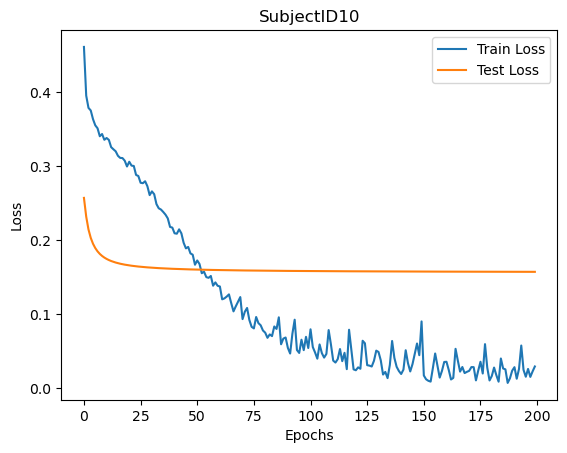

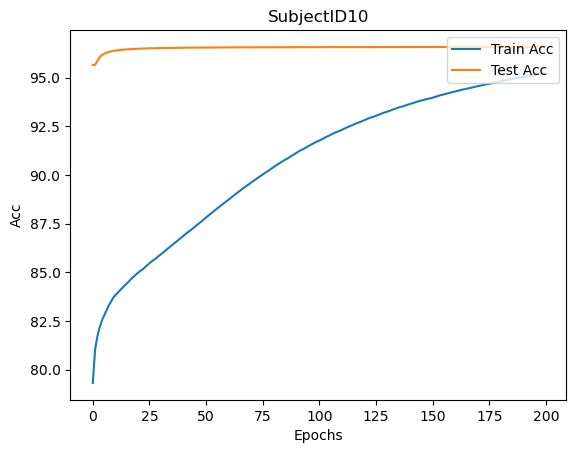


Subject 11
| epoch   0 | 0.3300 s/epoch | train loss 0.4896
| epoch   1 | 0.3282 s/epoch | train loss 0.3836
| epoch   2 | 0.3263 s/epoch | train loss 0.3289
| epoch   3 | 0.3260 s/epoch | train loss 0.3158
| epoch   4 | 0.3258 s/epoch | train loss 0.3068
| epoch   5 | 0.3252 s/epoch | train loss 0.2839
| epoch   6 | 0.3251 s/epoch | train loss 0.3041
| epoch   7 | 0.3240 s/epoch | train loss 0.3538
| epoch   8 | 0.3272 s/epoch | train loss 0.3464
| epoch   9 | 0.3240 s/epoch | train loss 0.3211
| epoch  10 | 0.3251 s/epoch | train loss 0.2998
| epoch  11 | 0.3254 s/epoch | train loss 0.2855
| epoch  12 | 0.3260 s/epoch | train loss 0.2745
| epoch  13 | 0.3261 s/epoch | train loss 0.2763
| epoch  14 | 0.3246 s/epoch | train loss 0.2574
| epoch  15 | 0.3232 s/epoch | train loss 0.2531
| epoch  16 | 0.3264 s/epoch | train loss 0.2427
| epoch  17 | 0.3246 s/epoch | train loss 0.2341
| epoch  18 | 0.3253 s/epoch | train loss 0.2328
| epoch  19 | 0.3261 s/epoch | train loss 0.2279
| epoch 

| epoch 167 | 0.3361 s/epoch | train loss 0.0892
| epoch 168 | 0.3349 s/epoch | train loss 0.0788
| epoch 169 | 0.3381 s/epoch | train loss 0.0852
| epoch 170 | 0.3355 s/epoch | train loss 0.0771
| epoch 171 | 0.3582 s/epoch | train loss 0.0930
| epoch 172 | 0.3361 s/epoch | train loss 0.0742
| epoch 173 | 0.4174 s/epoch | train loss 0.0779
| epoch 174 | 0.3349 s/epoch | train loss 0.0765
| epoch 175 | 0.3435 s/epoch | train loss 0.0873
| epoch 176 | 0.3632 s/epoch | train loss 0.0784
| epoch 177 | 0.3271 s/epoch | train loss 0.1485
| epoch 178 | 0.3288 s/epoch | train loss 0.0816
| epoch 179 | 0.3301 s/epoch | train loss 0.0759
| epoch 180 | 0.3290 s/epoch | train loss 0.0830
| epoch 181 | 0.4064 s/epoch | train loss 0.0765
| epoch 182 | 0.3305 s/epoch | train loss 0.0786
| epoch 183 | 0.3318 s/epoch | train loss 0.0804
| epoch 184 | 0.3321 s/epoch | train loss 0.0642
| epoch 185 | 0.3312 s/epoch | train loss 0.0754
| epoch 186 | 0.3321 s/epoch | train loss 0.0601
| epoch 187 | 0.3341

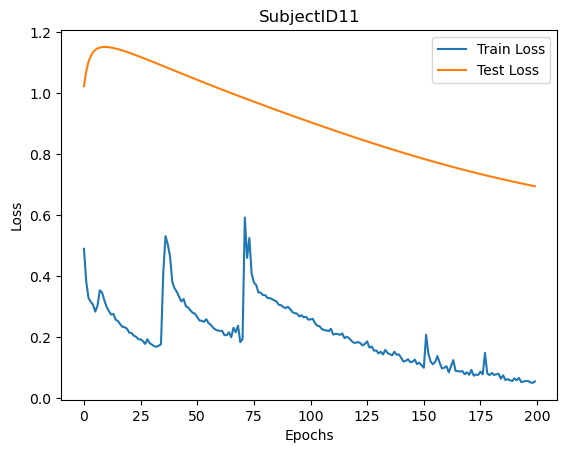

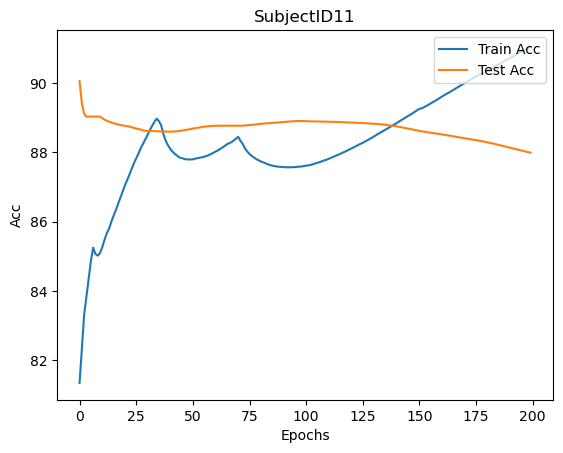

| epoch   0 | 0.0077 s/epoch | train loss 0.4504
| epoch   1 | 0.0074 s/epoch | train loss 0.3799
| epoch   2 | 0.0075 s/epoch | train loss 0.3749
| epoch   3 | 0.0080 s/epoch | train loss 0.3666
| epoch   4 | 0.0077 s/epoch | train loss 0.3596
| epoch   5 | 0.0078 s/epoch | train loss 0.3520
| epoch   6 | 0.0074 s/epoch | train loss 0.3441
| epoch   7 | 0.0081 s/epoch | train loss 0.3356
| epoch   8 | 0.0080 s/epoch | train loss 0.3305
| epoch   9 | 0.0081 s/epoch | train loss 0.3346
| epoch  10 | 0.0080 s/epoch | train loss 0.3198
| epoch  11 | 0.0079 s/epoch | train loss 0.3213
| epoch  12 | 0.0079 s/epoch | train loss 0.3161
| epoch  13 | 0.0078 s/epoch | train loss 0.3116
| epoch  14 | 0.0078 s/epoch | train loss 0.3074
| epoch  15 | 0.0077 s/epoch | train loss 0.3030
| epoch  16 | 0.0075 s/epoch | train loss 0.2995
| epoch  17 | 0.0081 s/epoch | train loss 0.2974
| epoch  18 | 0.0073 s/epoch | train loss 0.3006
| epoch  19 | 0.0082 s/epoch | train loss 0.3030
| epoch  20 | 0.0071

| epoch 168 | 0.0086 s/epoch | train loss 0.0403
| epoch 169 | 0.0075 s/epoch | train loss 0.0508
| epoch 170 | 0.0074 s/epoch | train loss 0.0558
| epoch 171 | 0.0077 s/epoch | train loss 0.0355
| epoch 172 | 0.0072 s/epoch | train loss 0.0767
| epoch 173 | 0.0075 s/epoch | train loss 0.0304
| epoch 174 | 0.0073 s/epoch | train loss 0.0231
| epoch 175 | 0.0073 s/epoch | train loss 0.0487
| epoch 176 | 0.0079 s/epoch | train loss 0.0336
| epoch 177 | 0.0071 s/epoch | train loss 0.0318
| epoch 178 | 0.0084 s/epoch | train loss 0.0330
| epoch 179 | 0.0079 s/epoch | train loss 0.0380
| epoch 180 | 0.0076 s/epoch | train loss 0.0405
| epoch 181 | 0.0074 s/epoch | train loss 0.0604
| epoch 182 | 0.0078 s/epoch | train loss 0.0382
| epoch 183 | 0.0075 s/epoch | train loss 0.0262
| epoch 184 | 0.0078 s/epoch | train loss 0.0272
| epoch 185 | 0.0075 s/epoch | train loss 0.0365
| epoch 186 | 0.0075 s/epoch | train loss 0.0343
| epoch 187 | 0.0075 s/epoch | train loss 0.0448
| epoch 188 | 0.0073

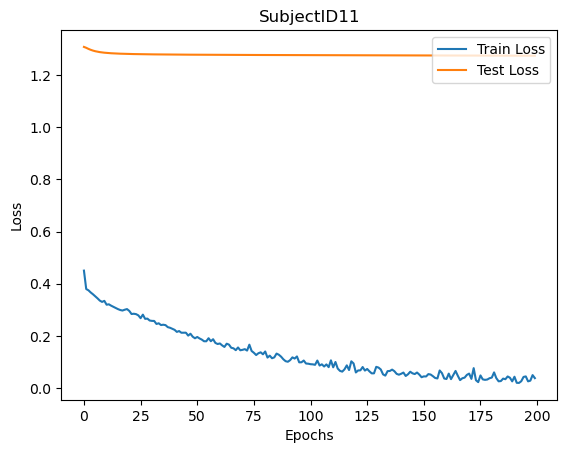

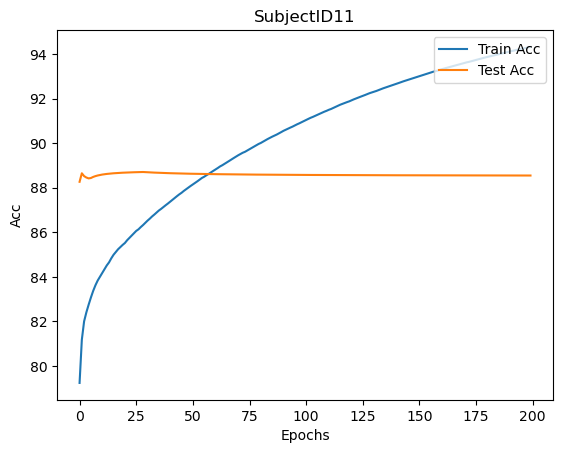


Subject 12
| epoch   0 | 0.3170 s/epoch | train loss 0.4549
| epoch   1 | 0.3191 s/epoch | train loss 0.3502
| epoch   2 | 0.3199 s/epoch | train loss 0.3240
| epoch   3 | 0.3283 s/epoch | train loss 0.3222
| epoch   4 | 0.3220 s/epoch | train loss 0.2938
| epoch   5 | 0.3205 s/epoch | train loss 0.2893
| epoch   6 | 0.3208 s/epoch | train loss 0.2817
| epoch   7 | 0.3964 s/epoch | train loss 0.2701
| epoch   8 | 0.3181 s/epoch | train loss 0.2663
| epoch   9 | 0.3189 s/epoch | train loss 0.2471
| epoch  10 | 0.3184 s/epoch | train loss 0.2449
| epoch  11 | 0.3210 s/epoch | train loss 0.2979
| epoch  12 | 0.3231 s/epoch | train loss 0.2956
| epoch  13 | 0.3215 s/epoch | train loss 0.2586
| epoch  14 | 0.3226 s/epoch | train loss 0.2189
| epoch  15 | 0.3194 s/epoch | train loss 0.2564
| epoch  16 | 0.3207 s/epoch | train loss 0.2265
| epoch  17 | 0.3184 s/epoch | train loss 0.2229
| epoch  18 | 0.3197 s/epoch | train loss 0.2098
| epoch  19 | 0.3202 s/epoch | train loss 0.2170
| epoch 

| epoch 167 | 0.3551 s/epoch | train loss 0.0975
| epoch 168 | 0.3578 s/epoch | train loss 0.0968
| epoch 169 | 0.3476 s/epoch | train loss 0.0867
| epoch 170 | 0.3466 s/epoch | train loss 0.1095
| epoch 171 | 0.3511 s/epoch | train loss 0.0666
| epoch 172 | 0.3649 s/epoch | train loss 0.0721
| epoch 173 | 0.3663 s/epoch | train loss 0.0576
| epoch 174 | 0.3608 s/epoch | train loss 0.0567
| epoch 175 | 0.3498 s/epoch | train loss 0.0656
| epoch 176 | 0.3461 s/epoch | train loss 0.0583
| epoch 177 | 0.3531 s/epoch | train loss 0.0628
| epoch 178 | 0.3577 s/epoch | train loss 0.0613
| epoch 179 | 0.3434 s/epoch | train loss 0.0654
| epoch 180 | 0.3461 s/epoch | train loss 0.0922
| epoch 181 | 0.3502 s/epoch | train loss 0.0745
| epoch 182 | 0.3529 s/epoch | train loss 0.0931
| epoch 183 | 0.3474 s/epoch | train loss 0.0585
| epoch 184 | 0.3476 s/epoch | train loss 0.0487
| epoch 185 | 0.3520 s/epoch | train loss 0.0556
| epoch 186 | 0.3617 s/epoch | train loss 0.0442
| epoch 187 | 0.3540

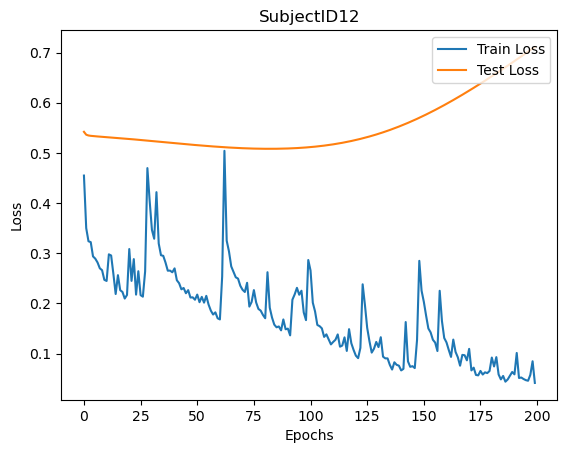

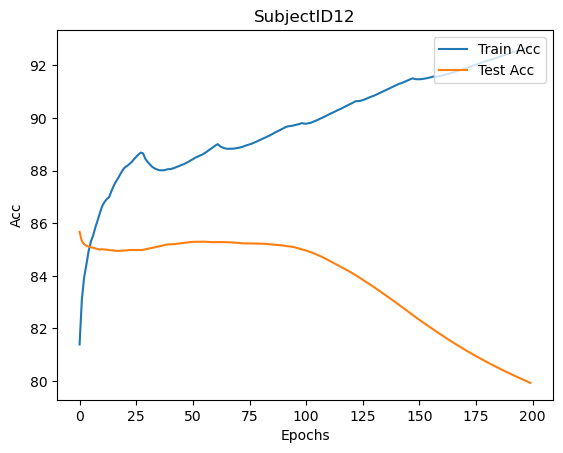

| epoch   0 | 0.0084 s/epoch | train loss 0.4480
| epoch   1 | 0.0078 s/epoch | train loss 0.3776
| epoch   2 | 0.0081 s/epoch | train loss 0.3698
| epoch   3 | 0.0086 s/epoch | train loss 0.3585
| epoch   4 | 0.0084 s/epoch | train loss 0.3504
| epoch   5 | 0.0087 s/epoch | train loss 0.3489
| epoch   6 | 0.0083 s/epoch | train loss 0.3394
| epoch   7 | 0.0087 s/epoch | train loss 0.3304
| epoch   8 | 0.0088 s/epoch | train loss 0.3233
| epoch   9 | 0.0084 s/epoch | train loss 0.3206
| epoch  10 | 0.0093 s/epoch | train loss 0.3211
| epoch  11 | 0.0089 s/epoch | train loss 0.3189
| epoch  12 | 0.0087 s/epoch | train loss 0.3097
| epoch  13 | 0.0088 s/epoch | train loss 0.3102
| epoch  14 | 0.0093 s/epoch | train loss 0.3050
| epoch  15 | 0.0094 s/epoch | train loss 0.2944
| epoch  16 | 0.0090 s/epoch | train loss 0.2931
| epoch  17 | 0.0087 s/epoch | train loss 0.2925
| epoch  18 | 0.0091 s/epoch | train loss 0.2891
| epoch  19 | 0.0086 s/epoch | train loss 0.2820
| epoch  20 | 0.0089

| epoch 168 | 0.0083 s/epoch | train loss 0.0521
| epoch 169 | 0.0085 s/epoch | train loss 0.0283
| epoch 170 | 0.0083 s/epoch | train loss 0.0262
| epoch 171 | 0.0090 s/epoch | train loss 0.0277
| epoch 172 | 0.0080 s/epoch | train loss 0.0624
| epoch 173 | 0.0087 s/epoch | train loss 0.0193
| epoch 174 | 0.0084 s/epoch | train loss 0.0184
| epoch 175 | 0.0085 s/epoch | train loss 0.0237
| epoch 176 | 0.0090 s/epoch | train loss 0.0409
| epoch 177 | 0.0088 s/epoch | train loss 0.0595
| epoch 178 | 0.0089 s/epoch | train loss 0.0445
| epoch 179 | 0.0086 s/epoch | train loss 0.0183
| epoch 180 | 0.0086 s/epoch | train loss 0.0134
| epoch 181 | 0.0094 s/epoch | train loss 0.0301
| epoch 182 | 0.0088 s/epoch | train loss 0.0476
| epoch 183 | 0.0085 s/epoch | train loss 0.0287
| epoch 184 | 0.0088 s/epoch | train loss 0.0239
| epoch 185 | 0.0084 s/epoch | train loss 0.0206
| epoch 186 | 0.0088 s/epoch | train loss 0.0432
| epoch 187 | 0.0085 s/epoch | train loss 0.1619
| epoch 188 | 0.0084

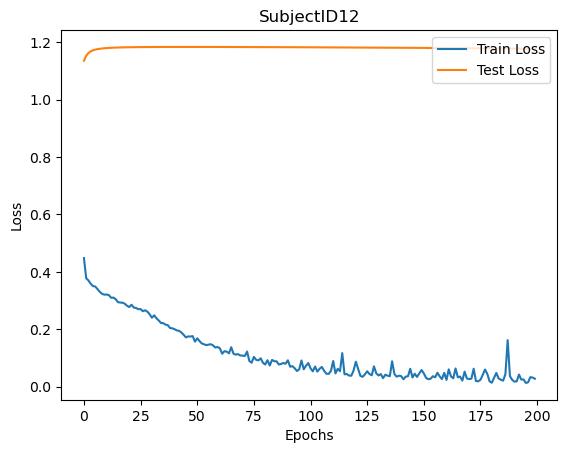

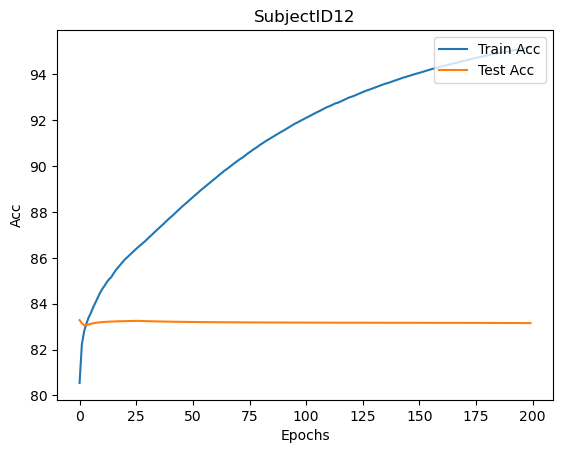


Subject 13
| epoch   0 | 0.3564 s/epoch | train loss 0.4644
| epoch   1 | 0.3650 s/epoch | train loss 0.4116
| epoch   2 | 0.3560 s/epoch | train loss 0.3387
| epoch   3 | 0.3523 s/epoch | train loss 0.3175
| epoch   4 | 0.3654 s/epoch | train loss 0.2982
| epoch   5 | 0.3365 s/epoch | train loss 0.2842
| epoch   6 | 0.3284 s/epoch | train loss 0.2720
| epoch   7 | 0.3287 s/epoch | train loss 0.2656
| epoch   8 | 0.3286 s/epoch | train loss 0.2598
| epoch   9 | 0.3294 s/epoch | train loss 0.2453
| epoch  10 | 0.3283 s/epoch | train loss 0.2401
| epoch  11 | 0.3287 s/epoch | train loss 0.2271
| epoch  12 | 0.3224 s/epoch | train loss 0.2287
| epoch  13 | 0.3248 s/epoch | train loss 0.2125
| epoch  14 | 0.3357 s/epoch | train loss 0.2163
| epoch  15 | 0.3392 s/epoch | train loss 0.2048
| epoch  16 | 0.3206 s/epoch | train loss 0.2010
| epoch  17 | 0.3228 s/epoch | train loss 0.2023
| epoch  18 | 0.3201 s/epoch | train loss 0.1988
| epoch  19 | 0.3221 s/epoch | train loss 0.2004
| epoch 

| epoch 167 | 0.3632 s/epoch | train loss 0.1246
| epoch 168 | 0.3554 s/epoch | train loss 0.1203
| epoch 169 | 0.3682 s/epoch | train loss 0.1276
| epoch 170 | 0.3678 s/epoch | train loss 0.1243
| epoch 171 | 0.3704 s/epoch | train loss 0.1273
| epoch 172 | 0.3693 s/epoch | train loss 0.1118
| epoch 173 | 0.3988 s/epoch | train loss 0.1191
| epoch 174 | 0.3964 s/epoch | train loss 0.1049
| epoch 175 | 0.3999 s/epoch | train loss 0.1168
| epoch 176 | 0.4002 s/epoch | train loss 0.1172
| epoch 177 | 0.3949 s/epoch | train loss 0.1021
| epoch 178 | 0.3714 s/epoch | train loss 0.1120
| epoch 179 | 0.3890 s/epoch | train loss 0.1083
| epoch 180 | 0.3847 s/epoch | train loss 0.0971
| epoch 181 | 0.3765 s/epoch | train loss 0.1025
| epoch 182 | 0.4019 s/epoch | train loss 0.1086
| epoch 183 | 0.4012 s/epoch | train loss 0.0932
| epoch 184 | 0.3925 s/epoch | train loss 0.1074
| epoch 185 | 0.3997 s/epoch | train loss 0.0959
| epoch 186 | 0.3705 s/epoch | train loss 0.0837
| epoch 187 | 0.3817

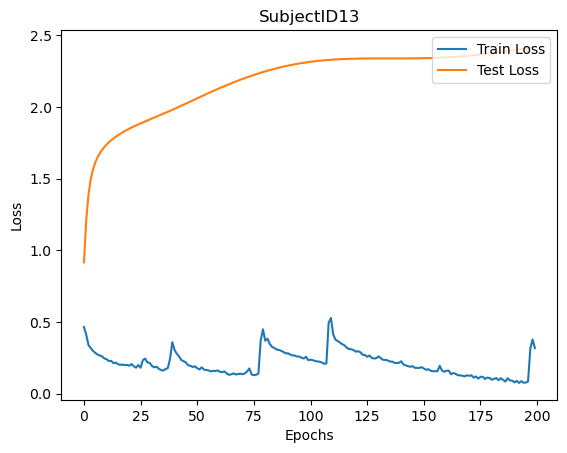

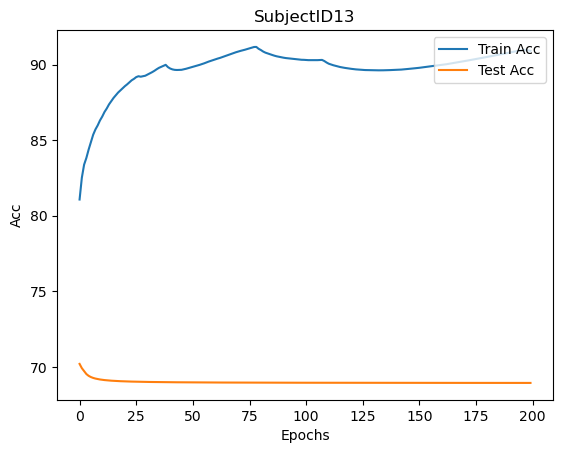

| epoch   0 | 0.0105 s/epoch | train loss 0.4403
| epoch   1 | 0.0103 s/epoch | train loss 0.3613
| epoch   2 | 0.0101 s/epoch | train loss 0.3525
| epoch   3 | 0.0094 s/epoch | train loss 0.3453
| epoch   4 | 0.0103 s/epoch | train loss 0.3411
| epoch   5 | 0.0099 s/epoch | train loss 0.3343
| epoch   6 | 0.0100 s/epoch | train loss 0.3299
| epoch   7 | 0.0097 s/epoch | train loss 0.3268
| epoch   8 | 0.0105 s/epoch | train loss 0.3158
| epoch   9 | 0.0102 s/epoch | train loss 0.3077
| epoch  10 | 0.0102 s/epoch | train loss 0.3026
| epoch  11 | 0.0097 s/epoch | train loss 0.3050
| epoch  12 | 0.0093 s/epoch | train loss 0.3040
| epoch  13 | 0.0094 s/epoch | train loss 0.2995
| epoch  14 | 0.0094 s/epoch | train loss 0.2934
| epoch  15 | 0.0097 s/epoch | train loss 0.2890
| epoch  16 | 0.0104 s/epoch | train loss 0.2818
| epoch  17 | 0.0100 s/epoch | train loss 0.2777
| epoch  18 | 0.0088 s/epoch | train loss 0.2766
| epoch  19 | 0.0095 s/epoch | train loss 0.2696
| epoch  20 | 0.0098

| epoch 168 | 0.0076 s/epoch | train loss 0.0194
| epoch 169 | 0.0080 s/epoch | train loss 0.0200
| epoch 170 | 0.0075 s/epoch | train loss 0.0339
| epoch 171 | 0.0075 s/epoch | train loss 0.0121
| epoch 172 | 0.0072 s/epoch | train loss 0.0135
| epoch 173 | 0.0077 s/epoch | train loss 0.0304
| epoch 174 | 0.0074 s/epoch | train loss 0.0448
| epoch 175 | 0.0074 s/epoch | train loss 0.0345
| epoch 176 | 0.0080 s/epoch | train loss 0.0243
| epoch 177 | 0.0072 s/epoch | train loss 0.0497
| epoch 178 | 0.0071 s/epoch | train loss 0.0529
| epoch 179 | 0.0073 s/epoch | train loss 0.0144
| epoch 180 | 0.0074 s/epoch | train loss 0.0101
| epoch 181 | 0.0080 s/epoch | train loss 0.0189
| epoch 182 | 0.0074 s/epoch | train loss 0.0247
| epoch 183 | 0.0074 s/epoch | train loss 0.0158
| epoch 184 | 0.0075 s/epoch | train loss 0.0195
| epoch 185 | 0.0086 s/epoch | train loss 0.0251
| epoch 186 | 0.0071 s/epoch | train loss 0.0264
| epoch 187 | 0.0075 s/epoch | train loss 0.0383
| epoch 188 | 0.0079

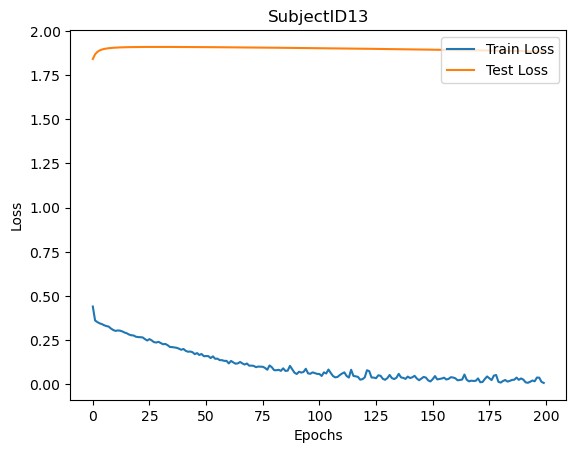

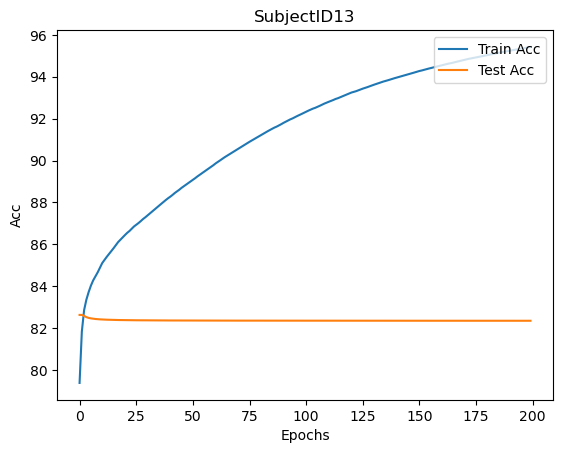


Subject 14
| epoch   0 | 0.3301 s/epoch | train loss 0.4979
| epoch   1 | 0.3284 s/epoch | train loss 0.4103
| epoch   2 | 0.3290 s/epoch | train loss 0.3326
| epoch   3 | 0.3300 s/epoch | train loss 0.3345
| epoch   4 | 0.3293 s/epoch | train loss 0.4965
| epoch   5 | 0.3288 s/epoch | train loss 0.4559
| epoch   6 | 0.3303 s/epoch | train loss 0.4161
| epoch   7 | 0.3288 s/epoch | train loss 0.4407
| epoch   8 | 0.3308 s/epoch | train loss 0.3991
| epoch   9 | 0.3280 s/epoch | train loss 0.3582
| epoch  10 | 0.3284 s/epoch | train loss 0.3483
| epoch  11 | 0.3295 s/epoch | train loss 0.3415
| epoch  12 | 0.3294 s/epoch | train loss 0.3464
| epoch  13 | 0.3294 s/epoch | train loss 0.3796
| epoch  14 | 0.3289 s/epoch | train loss 0.3524
| epoch  15 | 0.3294 s/epoch | train loss 0.3312
| epoch  16 | 0.3285 s/epoch | train loss 0.3147
| epoch  17 | 0.3308 s/epoch | train loss 0.3047
| epoch  18 | 0.3295 s/epoch | train loss 0.3156
| epoch  19 | 0.3317 s/epoch | train loss 0.5067
| epoch 

| epoch 167 | 0.3275 s/epoch | train loss 0.3785
| epoch 168 | 0.3263 s/epoch | train loss 0.4088
| epoch 169 | 0.3262 s/epoch | train loss 0.4061
| epoch 170 | 0.3277 s/epoch | train loss 0.3821
| epoch 171 | 0.3255 s/epoch | train loss 0.4111
| epoch 172 | 0.3274 s/epoch | train loss 0.3865
| epoch 173 | 0.3262 s/epoch | train loss 0.3770
| epoch 174 | 0.3255 s/epoch | train loss 0.3705
| epoch 175 | 0.3260 s/epoch | train loss 0.3580
| epoch 176 | 0.3256 s/epoch | train loss 0.3570
| epoch 177 | 0.3253 s/epoch | train loss 0.3451
| epoch 178 | 0.3256 s/epoch | train loss 0.3393
| epoch 179 | 0.3253 s/epoch | train loss 0.3433
| epoch 180 | 0.3236 s/epoch | train loss 0.3485
| epoch 181 | 0.3248 s/epoch | train loss 0.3685
| epoch 182 | 0.3261 s/epoch | train loss 0.3454
| epoch 183 | 0.3251 s/epoch | train loss 0.3302
| epoch 184 | 0.3250 s/epoch | train loss 0.3246
| epoch 185 | 0.3248 s/epoch | train loss 0.3256
| epoch 186 | 0.3261 s/epoch | train loss 0.3234
| epoch 187 | 0.3268

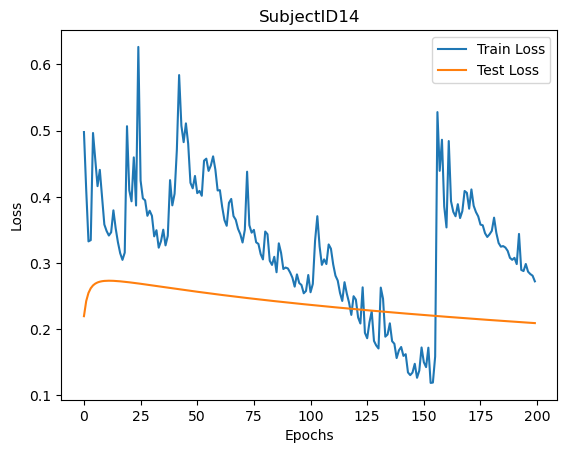

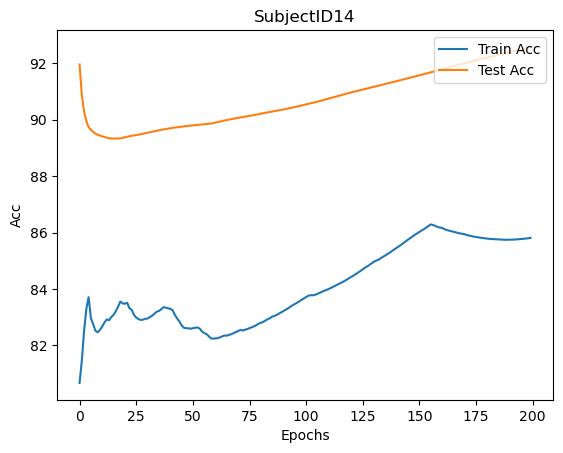

| epoch   0 | 0.0073 s/epoch | train loss 0.4605
| epoch   1 | 0.0079 s/epoch | train loss 0.3853
| epoch   2 | 0.0078 s/epoch | train loss 0.3750
| epoch   3 | 0.0073 s/epoch | train loss 0.3684
| epoch   4 | 0.0076 s/epoch | train loss 0.3591
| epoch   5 | 0.0083 s/epoch | train loss 0.3519
| epoch   6 | 0.0082 s/epoch | train loss 0.3517
| epoch   7 | 0.0073 s/epoch | train loss 0.3420
| epoch   8 | 0.0073 s/epoch | train loss 0.3424
| epoch   9 | 0.0076 s/epoch | train loss 0.3343
| epoch  10 | 0.0076 s/epoch | train loss 0.3322
| epoch  11 | 0.0077 s/epoch | train loss 0.3283
| epoch  12 | 0.0075 s/epoch | train loss 0.3185
| epoch  13 | 0.0071 s/epoch | train loss 0.3153
| epoch  14 | 0.0081 s/epoch | train loss 0.3198
| epoch  15 | 0.0076 s/epoch | train loss 0.3327
| epoch  16 | 0.0076 s/epoch | train loss 0.3168
| epoch  17 | 0.0076 s/epoch | train loss 0.3099
| epoch  18 | 0.0079 s/epoch | train loss 0.3053
| epoch  19 | 0.0075 s/epoch | train loss 0.3006
| epoch  20 | 0.0074

| epoch 168 | 0.0077 s/epoch | train loss 0.0270
| epoch 169 | 0.0077 s/epoch | train loss 0.0173
| epoch 170 | 0.0082 s/epoch | train loss 0.0321
| epoch 171 | 0.0078 s/epoch | train loss 0.0609
| epoch 172 | 0.0079 s/epoch | train loss 0.0325
| epoch 173 | 0.0082 s/epoch | train loss 0.0747
| epoch 174 | 0.0082 s/epoch | train loss 0.0194
| epoch 175 | 0.0077 s/epoch | train loss 0.0157
| epoch 176 | 0.0088 s/epoch | train loss 0.0171
| epoch 177 | 0.0077 s/epoch | train loss 0.0471
| epoch 178 | 0.0081 s/epoch | train loss 0.0228
| epoch 179 | 0.0083 s/epoch | train loss 0.0281
| epoch 180 | 0.0077 s/epoch | train loss 0.0425
| epoch 181 | 0.0082 s/epoch | train loss 0.0256
| epoch 182 | 0.0082 s/epoch | train loss 0.0133
| epoch 183 | 0.0075 s/epoch | train loss 0.0128
| epoch 184 | 0.0076 s/epoch | train loss 0.0162
| epoch 185 | 0.0073 s/epoch | train loss 0.0396
| epoch 186 | 0.0075 s/epoch | train loss 0.0223
| epoch 187 | 0.0079 s/epoch | train loss 0.0209
| epoch 188 | 0.0085

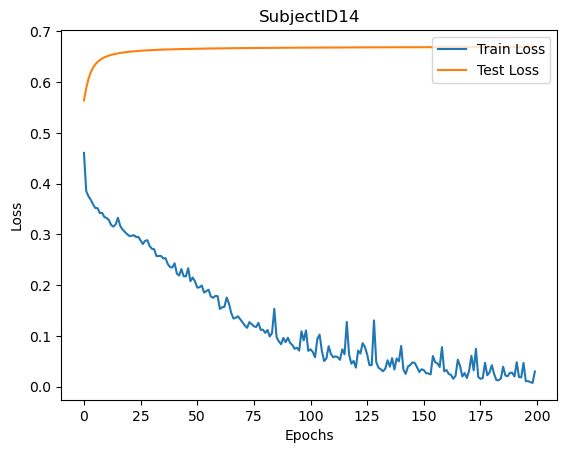

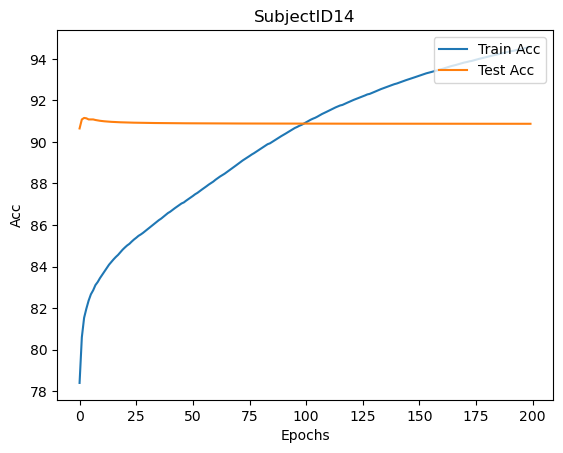


Subject 15
| epoch   0 | 0.3398 s/epoch | train loss 0.4984
| epoch   1 | 0.3391 s/epoch | train loss 0.3857
| epoch   2 | 0.3388 s/epoch | train loss 0.3752
| epoch   3 | 0.3382 s/epoch | train loss 0.3258
| epoch   4 | 0.3388 s/epoch | train loss 0.3396
| epoch   5 | 0.3387 s/epoch | train loss 0.3208
| epoch   6 | 0.3399 s/epoch | train loss 0.2944
| epoch   7 | 0.3391 s/epoch | train loss 0.3709
| epoch   8 | 0.3387 s/epoch | train loss 0.4283
| epoch   9 | 0.3389 s/epoch | train loss 0.3153
| epoch  10 | 0.3380 s/epoch | train loss 0.2803
| epoch  11 | 0.3399 s/epoch | train loss 0.2728
| epoch  12 | 0.3387 s/epoch | train loss 0.2624
| epoch  13 | 0.3377 s/epoch | train loss 0.2464
| epoch  14 | 0.3404 s/epoch | train loss 0.2468
| epoch  15 | 0.3390 s/epoch | train loss 0.2385
| epoch  16 | 0.3394 s/epoch | train loss 0.2308
| epoch  17 | 0.3381 s/epoch | train loss 0.2228
| epoch  18 | 0.3376 s/epoch | train loss 0.2278
| epoch  19 | 0.3398 s/epoch | train loss 0.2194
| epoch 

| epoch 167 | 0.3391 s/epoch | train loss 0.0582
| epoch 168 | 0.3408 s/epoch | train loss 0.0532
| epoch 169 | 0.3382 s/epoch | train loss 0.0602
| epoch 170 | 0.3393 s/epoch | train loss 0.0684
| epoch 171 | 0.3401 s/epoch | train loss 0.0509
| epoch 172 | 0.3411 s/epoch | train loss 0.0560
| epoch 173 | 0.3402 s/epoch | train loss 0.0560
| epoch 174 | 0.3403 s/epoch | train loss 0.0533
| epoch 175 | 0.3394 s/epoch | train loss 0.0644
| epoch 176 | 0.3392 s/epoch | train loss 0.0484
| epoch 177 | 0.3398 s/epoch | train loss 0.0480
| epoch 178 | 0.3408 s/epoch | train loss 0.0498
| epoch 179 | 0.3414 s/epoch | train loss 0.0576
| epoch 180 | 0.3396 s/epoch | train loss 0.0458
| epoch 181 | 0.3392 s/epoch | train loss 0.0604
| epoch 182 | 0.3381 s/epoch | train loss 0.0421
| epoch 183 | 0.3401 s/epoch | train loss 0.0448
| epoch 184 | 0.3402 s/epoch | train loss 0.0496
| epoch 185 | 0.3283 s/epoch | train loss 0.0333
| epoch 186 | 0.3166 s/epoch | train loss 0.0454
| epoch 187 | 0.3164

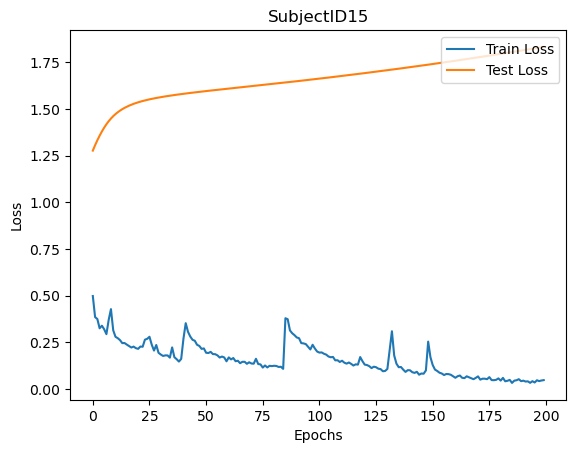

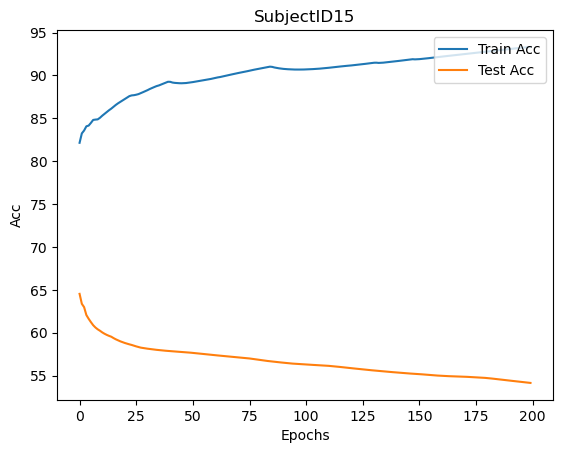

| epoch   0 | 0.0085 s/epoch | train loss 0.4431
| epoch   1 | 0.0078 s/epoch | train loss 0.3629
| epoch   2 | 0.0078 s/epoch | train loss 0.3564
| epoch   3 | 0.0084 s/epoch | train loss 0.3476
| epoch   4 | 0.0082 s/epoch | train loss 0.3382
| epoch   5 | 0.0085 s/epoch | train loss 0.3334
| epoch   6 | 0.0081 s/epoch | train loss 0.3281
| epoch   7 | 0.0077 s/epoch | train loss 0.3204
| epoch   8 | 0.0082 s/epoch | train loss 0.3159
| epoch   9 | 0.0085 s/epoch | train loss 0.3075
| epoch  10 | 0.0083 s/epoch | train loss 0.3049
| epoch  11 | 0.0083 s/epoch | train loss 0.3039
| epoch  12 | 0.0090 s/epoch | train loss 0.2965
| epoch  13 | 0.0085 s/epoch | train loss 0.2905
| epoch  14 | 0.0082 s/epoch | train loss 0.2854
| epoch  15 | 0.0078 s/epoch | train loss 0.2835
| epoch  16 | 0.0083 s/epoch | train loss 0.2732
| epoch  17 | 0.0083 s/epoch | train loss 0.2669
| epoch  18 | 0.0084 s/epoch | train loss 0.2687
| epoch  19 | 0.0076 s/epoch | train loss 0.2638
| epoch  20 | 0.0078

| epoch 168 | 0.0085 s/epoch | train loss 0.0255
| epoch 169 | 0.0082 s/epoch | train loss 0.0166
| epoch 170 | 0.0083 s/epoch | train loss 0.0207
| epoch 171 | 0.0077 s/epoch | train loss 0.0237
| epoch 172 | 0.0078 s/epoch | train loss 0.0205
| epoch 173 | 0.0080 s/epoch | train loss 0.0251
| epoch 174 | 0.0081 s/epoch | train loss 0.0157
| epoch 175 | 0.0079 s/epoch | train loss 0.0196
| epoch 176 | 0.0084 s/epoch | train loss 0.0182
| epoch 177 | 0.0081 s/epoch | train loss 0.0514
| epoch 178 | 0.0078 s/epoch | train loss 0.0194
| epoch 179 | 0.0078 s/epoch | train loss 0.0115
| epoch 180 | 0.0086 s/epoch | train loss 0.0318
| epoch 181 | 0.0081 s/epoch | train loss 0.0141
| epoch 182 | 0.0078 s/epoch | train loss 0.0152
| epoch 183 | 0.0083 s/epoch | train loss 0.0141
| epoch 184 | 0.0080 s/epoch | train loss 0.0256
| epoch 185 | 0.0084 s/epoch | train loss 0.0182
| epoch 186 | 0.0088 s/epoch | train loss 0.0463
| epoch 187 | 0.0081 s/epoch | train loss 0.0326
| epoch 188 | 0.0077

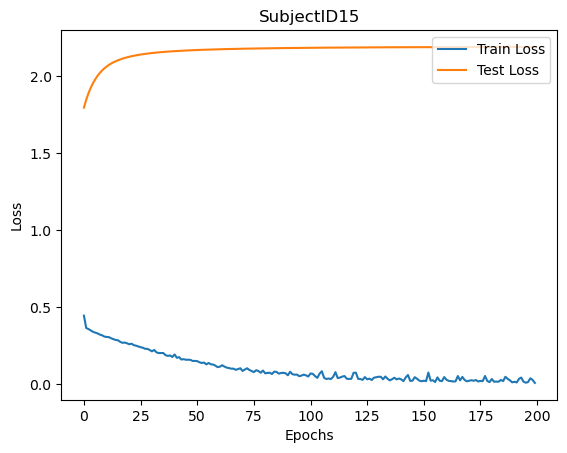

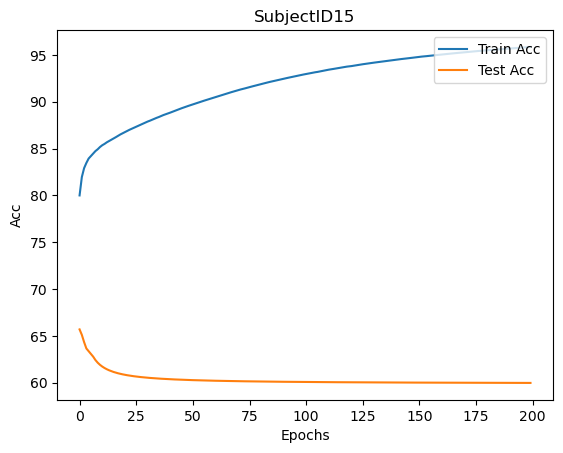

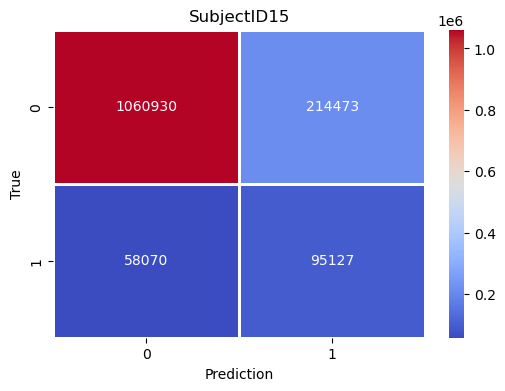

<Figure size 640x480 with 0 Axes>

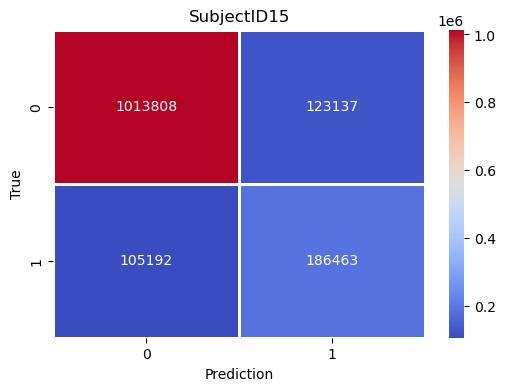

Teacher(RestNet50)_Acc: 0.8092237155256895
Teacher(RestNet50)_Rec: 0.6209455798742796
Teacher(RestNet50)_Pre: 0.3072577519379845
Teacher(RestNet50)_F1: 0.4110960096975564
Original_Student(CNN)_Acc: 0.8401728965420692
Original_Student(CNN)_Rec: 0.6393272873772093
Original_Student(CNN)_Pre: 0.6022706718346253
Original_Student(CNN)_F1: 0.6202459854803702


<Figure size 640x480 with 0 Axes>

In [11]:

#%% Evaluation
def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])

#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []

Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []


teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []

#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [3, 8, 36, 3], 1, 2)
    model_teacher = ResNet.to(device) 
    model_teacher.train()

    model_student = Net_Student(config).to(device) 
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher(RestNet50)_Acc:",Teacher_eval_table[0])
print("Teacher(RestNet50)_Rec:",Teacher_eval_table[1])
print("Teacher(RestNet50)_Pre:",Teacher_eval_table[2])
print("Teacher(RestNet50)_F1:",Teacher_eval_table[3])

print("Original_Student(CNN)_Acc:",Student_eval_table[0])
print("Original_Student(CNN)_Rec:",Student_eval_table[1])
print("Original_Student(CNN)_Pre:",Student_eval_table[2])
print("Original_Student(CNN)_F1:",Student_eval_table[3])     


Subject 1
| epoch   0 | 0.2485 s/epoch | train loss 2.1938
| epoch   1 | 0.2518 s/epoch | train loss 1.3278
| epoch   2 | 0.2509 s/epoch | train loss 1.2616
| epoch   3 | 0.2497 s/epoch | train loss 1.1949
| epoch   4 | 0.2484 s/epoch | train loss 1.1561
| epoch   5 | 0.2509 s/epoch | train loss 1.1568
| epoch   6 | 0.2495 s/epoch | train loss 1.0997
| epoch   7 | 0.2509 s/epoch | train loss 1.1033
| epoch   8 | 0.2514 s/epoch | train loss 1.0579
| epoch   9 | 0.2491 s/epoch | train loss 1.0555
| epoch  10 | 0.2491 s/epoch | train loss 1.0350
| epoch  11 | 0.2494 s/epoch | train loss 0.9860
| epoch  12 | 0.2507 s/epoch | train loss 0.9764
| epoch  13 | 0.2489 s/epoch | train loss 0.9650
| epoch  14 | 0.2502 s/epoch | train loss 0.9773
| epoch  15 | 0.2504 s/epoch | train loss 0.9471
| epoch  16 | 0.2492 s/epoch | train loss 0.8978
| epoch  17 | 0.2510 s/epoch | train loss 0.9087
| epoch  18 | 0.2503 s/epoch | train loss 0.8924
| epoch  19 | 0.2485 s/epoch | train loss 0.8600
| epoch  

| epoch 167 | 0.2488 s/epoch | train loss 0.2208
| epoch 168 | 0.2504 s/epoch | train loss 0.1490
| epoch 169 | 0.2520 s/epoch | train loss 0.1287
| epoch 170 | 0.2497 s/epoch | train loss 0.1214
| epoch 171 | 0.2503 s/epoch | train loss 0.1141
| epoch 172 | 0.2488 s/epoch | train loss 0.1118
| epoch 173 | 0.2499 s/epoch | train loss 0.1134
| epoch 174 | 0.2494 s/epoch | train loss 0.1081
| epoch 175 | 0.2490 s/epoch | train loss 0.1080
| epoch 176 | 0.2526 s/epoch | train loss 0.1040
| epoch 177 | 0.2504 s/epoch | train loss 0.1063
| epoch 178 | 0.2479 s/epoch | train loss 0.2463
| epoch 179 | 0.2493 s/epoch | train loss 0.2496
| epoch 180 | 0.2493 s/epoch | train loss 0.1649
| epoch 181 | 0.2494 s/epoch | train loss 0.1260
| epoch 182 | 0.2497 s/epoch | train loss 0.1076
| epoch 183 | 0.2499 s/epoch | train loss 0.1031
| epoch 184 | 0.2504 s/epoch | train loss 0.0992
| epoch 185 | 0.2507 s/epoch | train loss 0.0974
| epoch 186 | 0.2495 s/epoch | train loss 0.1165
| epoch 187 | 0.2496

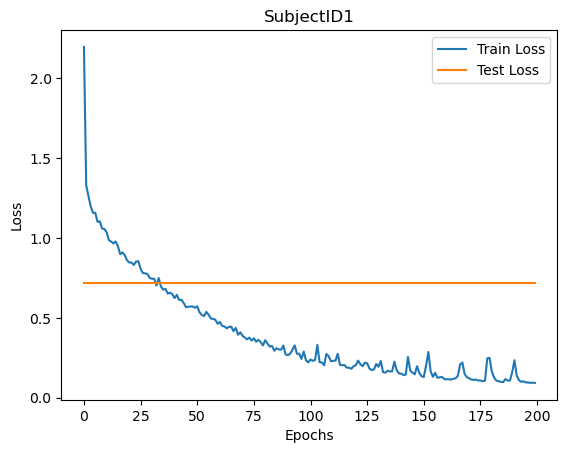

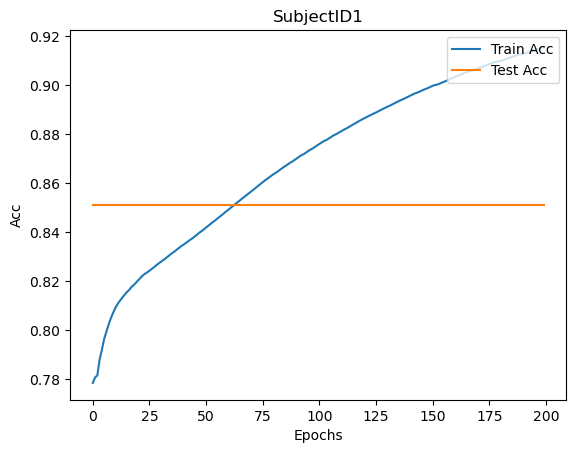


Subject 2
| epoch   0 | 0.2419 s/epoch | train loss 2.1253
| epoch   1 | 0.2432 s/epoch | train loss 1.3472
| epoch   2 | 0.2435 s/epoch | train loss 1.2633
| epoch   3 | 0.2426 s/epoch | train loss 1.1960
| epoch   4 | 0.2428 s/epoch | train loss 1.1401
| epoch   5 | 0.2421 s/epoch | train loss 1.1486
| epoch   6 | 0.2419 s/epoch | train loss 1.1014
| epoch   7 | 0.2407 s/epoch | train loss 1.0693
| epoch   8 | 0.2424 s/epoch | train loss 1.1020
| epoch   9 | 0.2425 s/epoch | train loss 1.0616
| epoch  10 | 0.2437 s/epoch | train loss 1.0770
| epoch  11 | 0.2421 s/epoch | train loss 1.0471
| epoch  12 | 0.2429 s/epoch | train loss 1.0027
| epoch  13 | 0.2420 s/epoch | train loss 1.0012
| epoch  14 | 0.2437 s/epoch | train loss 0.9691
| epoch  15 | 0.2423 s/epoch | train loss 0.9572
| epoch  16 | 0.2428 s/epoch | train loss 0.9742
| epoch  17 | 0.2428 s/epoch | train loss 0.9547
| epoch  18 | 0.2420 s/epoch | train loss 0.9552
| epoch  19 | 0.2430 s/epoch | train loss 0.9220
| epoch  

| epoch 167 | 0.2426 s/epoch | train loss 0.1929
| epoch 168 | 0.2445 s/epoch | train loss 0.2441
| epoch 169 | 0.2435 s/epoch | train loss 0.1508
| epoch 170 | 0.2431 s/epoch | train loss 0.1379
| epoch 171 | 0.2430 s/epoch | train loss 0.1526
| epoch 172 | 0.2436 s/epoch | train loss 0.1363
| epoch 173 | 0.2436 s/epoch | train loss 0.1301
| epoch 174 | 0.2415 s/epoch | train loss 0.1334
| epoch 175 | 0.2439 s/epoch | train loss 0.1339
| epoch 176 | 0.2417 s/epoch | train loss 0.1326
| epoch 177 | 0.2439 s/epoch | train loss 0.1269
| epoch 178 | 0.2423 s/epoch | train loss 0.1238
| epoch 179 | 0.2439 s/epoch | train loss 0.1258
| epoch 180 | 0.2435 s/epoch | train loss 0.1298
| epoch 181 | 0.2422 s/epoch | train loss 0.1665
| epoch 182 | 0.2435 s/epoch | train loss 0.2184
| epoch 183 | 0.2430 s/epoch | train loss 0.1904
| epoch 184 | 0.2432 s/epoch | train loss 0.1524
| epoch 185 | 0.2431 s/epoch | train loss 0.1700
| epoch 186 | 0.2429 s/epoch | train loss 0.1486
| epoch 187 | 0.2425

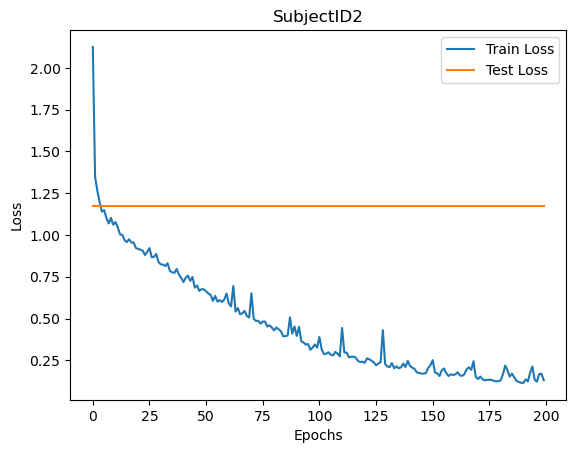

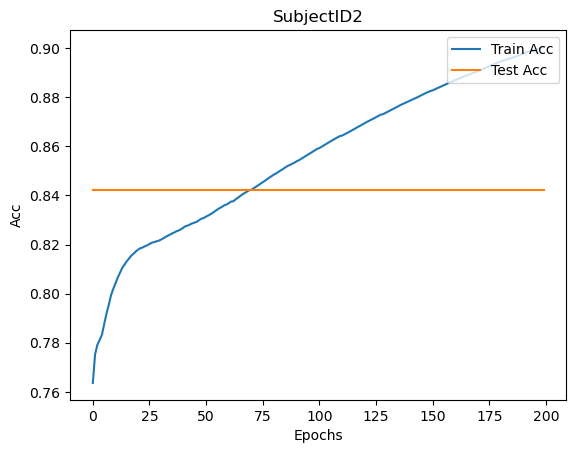


Subject 3
| epoch   0 | 0.2437 s/epoch | train loss 2.0112
| epoch   1 | 0.2414 s/epoch | train loss 1.2666
| epoch   2 | 0.2432 s/epoch | train loss 1.2219
| epoch   3 | 0.2432 s/epoch | train loss 1.1321
| epoch   4 | 0.2432 s/epoch | train loss 1.1288
| epoch   5 | 0.2432 s/epoch | train loss 1.1191
| epoch   6 | 0.2426 s/epoch | train loss 1.0714
| epoch   7 | 0.2441 s/epoch | train loss 1.0221
| epoch   8 | 0.2430 s/epoch | train loss 0.9994
| epoch   9 | 0.2420 s/epoch | train loss 0.9928
| epoch  10 | 0.2438 s/epoch | train loss 0.9494
| epoch  11 | 0.2415 s/epoch | train loss 0.9333
| epoch  12 | 0.2425 s/epoch | train loss 0.9213
| epoch  13 | 0.2435 s/epoch | train loss 0.8815
| epoch  14 | 0.2426 s/epoch | train loss 0.8635
| epoch  15 | 0.2434 s/epoch | train loss 0.8593
| epoch  16 | 0.2437 s/epoch | train loss 0.8274
| epoch  17 | 0.2424 s/epoch | train loss 0.8219
| epoch  18 | 0.2429 s/epoch | train loss 0.8176
| epoch  19 | 0.2434 s/epoch | train loss 0.8096
| epoch  

| epoch 167 | 0.2431 s/epoch | train loss 0.1217
| epoch 168 | 0.2436 s/epoch | train loss 0.1382
| epoch 169 | 0.2446 s/epoch | train loss 0.1794
| epoch 170 | 0.2427 s/epoch | train loss 0.1290
| epoch 171 | 0.2437 s/epoch | train loss 0.1411
| epoch 172 | 0.2431 s/epoch | train loss 0.1795
| epoch 173 | 0.2426 s/epoch | train loss 0.1424
| epoch 174 | 0.2432 s/epoch | train loss 0.1345
| epoch 175 | 0.2424 s/epoch | train loss 0.1403
| epoch 176 | 0.2419 s/epoch | train loss 0.1356
| epoch 177 | 0.2432 s/epoch | train loss 0.1178
| epoch 178 | 0.2436 s/epoch | train loss 0.1073
| epoch 179 | 0.2419 s/epoch | train loss 0.1011
| epoch 180 | 0.2427 s/epoch | train loss 0.1055
| epoch 181 | 0.2442 s/epoch | train loss 0.1020
| epoch 182 | 0.2433 s/epoch | train loss 0.0989
| epoch 183 | 0.2433 s/epoch | train loss 0.1004
| epoch 184 | 0.2460 s/epoch | train loss 0.0982
| epoch 185 | 0.2432 s/epoch | train loss 0.1069
| epoch 186 | 0.2438 s/epoch | train loss 0.1143
| epoch 187 | 0.2425

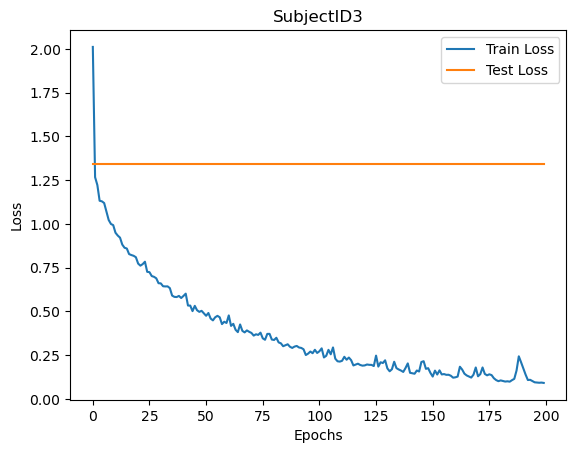

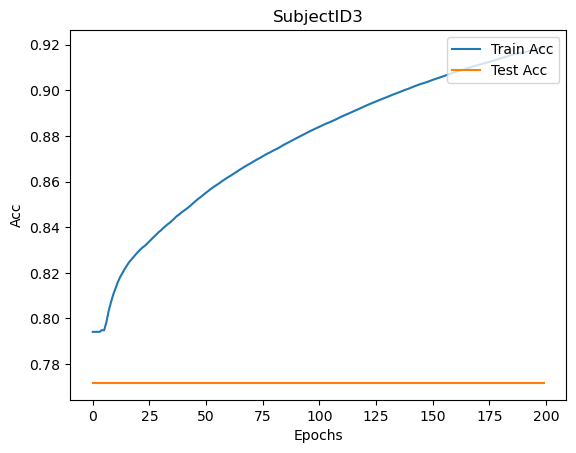


Subject 4
| epoch   0 | 0.2550 s/epoch | train loss 2.1428
| epoch   1 | 0.2550 s/epoch | train loss 1.3598
| epoch   2 | 0.2555 s/epoch | train loss 1.3118
| epoch   3 | 0.2536 s/epoch | train loss 1.2527
| epoch   4 | 0.2539 s/epoch | train loss 1.2309
| epoch   5 | 0.2554 s/epoch | train loss 1.1611
| epoch   6 | 0.2549 s/epoch | train loss 1.1153
| epoch   7 | 0.2563 s/epoch | train loss 1.0914
| epoch   8 | 0.2552 s/epoch | train loss 1.0786
| epoch   9 | 0.2557 s/epoch | train loss 1.0739
| epoch  10 | 0.2536 s/epoch | train loss 1.0585
| epoch  11 | 0.2542 s/epoch | train loss 1.0468
| epoch  12 | 0.2560 s/epoch | train loss 0.9895
| epoch  13 | 0.2563 s/epoch | train loss 0.9655
| epoch  14 | 0.2547 s/epoch | train loss 0.9407
| epoch  15 | 0.2558 s/epoch | train loss 0.9379
| epoch  16 | 0.2548 s/epoch | train loss 0.9183
| epoch  17 | 0.2552 s/epoch | train loss 0.9034
| epoch  18 | 0.2540 s/epoch | train loss 0.8891
| epoch  19 | 0.2534 s/epoch | train loss 0.8577
| epoch  

| epoch 167 | 0.2549 s/epoch | train loss 0.1251
| epoch 168 | 0.2545 s/epoch | train loss 0.1275
| epoch 169 | 0.2538 s/epoch | train loss 0.1266
| epoch 170 | 0.2557 s/epoch | train loss 0.1209
| epoch 171 | 0.2551 s/epoch | train loss 0.1208
| epoch 172 | 0.2531 s/epoch | train loss 0.1268
| epoch 173 | 0.2564 s/epoch | train loss 0.1290
| epoch 174 | 0.2558 s/epoch | train loss 0.1627
| epoch 175 | 0.2538 s/epoch | train loss 0.1951
| epoch 176 | 0.2540 s/epoch | train loss 0.1630
| epoch 177 | 0.2550 s/epoch | train loss 0.1690
| epoch 178 | 0.2534 s/epoch | train loss 0.1415
| epoch 179 | 0.2548 s/epoch | train loss 0.1516
| epoch 180 | 0.2558 s/epoch | train loss 0.1442
| epoch 181 | 0.2515 s/epoch | train loss 0.1346
| epoch 182 | 0.2559 s/epoch | train loss 0.1310
| epoch 183 | 0.2551 s/epoch | train loss 0.1770
| epoch 184 | 0.2550 s/epoch | train loss 0.1475
| epoch 185 | 0.2548 s/epoch | train loss 0.1553
| epoch 186 | 0.2552 s/epoch | train loss 0.1214
| epoch 187 | 0.2533

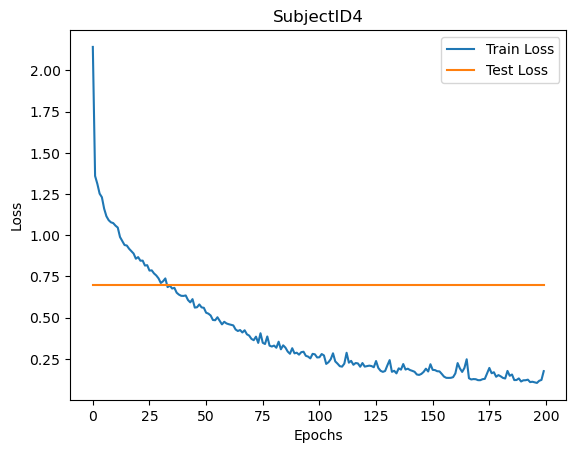

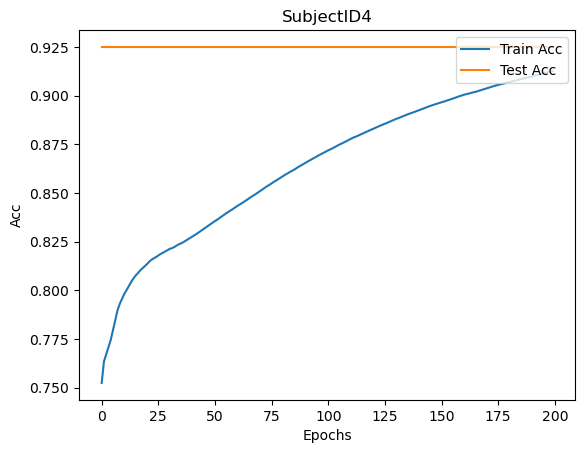


Subject 5
| epoch   0 | 0.2446 s/epoch | train loss 2.2339
| epoch   1 | 0.2435 s/epoch | train loss 1.3143
| epoch   2 | 0.2457 s/epoch | train loss 1.2620
| epoch   3 | 0.2458 s/epoch | train loss 1.2193
| epoch   4 | 0.2454 s/epoch | train loss 1.1887
| epoch   5 | 0.2424 s/epoch | train loss 1.1797
| epoch   6 | 0.2428 s/epoch | train loss 1.1430
| epoch   7 | 0.2435 s/epoch | train loss 1.1176
| epoch   8 | 0.2443 s/epoch | train loss 1.1108
| epoch   9 | 0.2440 s/epoch | train loss 1.0826
| epoch  10 | 0.2433 s/epoch | train loss 1.0787
| epoch  11 | 0.2440 s/epoch | train loss 1.0392
| epoch  12 | 0.2440 s/epoch | train loss 1.0411
| epoch  13 | 0.2438 s/epoch | train loss 1.0115
| epoch  14 | 0.2443 s/epoch | train loss 0.9804
| epoch  15 | 0.2464 s/epoch | train loss 0.9847
| epoch  16 | 0.2442 s/epoch | train loss 0.9645
| epoch  17 | 0.2437 s/epoch | train loss 0.9403
| epoch  18 | 0.2449 s/epoch | train loss 0.9254
| epoch  19 | 0.2442 s/epoch | train loss 0.9252
| epoch  

| epoch 167 | 0.2451 s/epoch | train loss 0.1287
| epoch 168 | 0.2446 s/epoch | train loss 0.1276
| epoch 169 | 0.2450 s/epoch | train loss 0.1256
| epoch 170 | 0.2444 s/epoch | train loss 0.1255
| epoch 171 | 0.2444 s/epoch | train loss 0.1423
| epoch 172 | 0.2409 s/epoch | train loss 0.1303
| epoch 173 | 0.2451 s/epoch | train loss 0.1378
| epoch 174 | 0.2459 s/epoch | train loss 0.2417
| epoch 175 | 0.2430 s/epoch | train loss 0.2327
| epoch 176 | 0.2436 s/epoch | train loss 0.1685
| epoch 177 | 0.2435 s/epoch | train loss 0.1334
| epoch 178 | 0.2444 s/epoch | train loss 0.1227
| epoch 179 | 0.2462 s/epoch | train loss 0.1187
| epoch 180 | 0.2441 s/epoch | train loss 0.1127
| epoch 181 | 0.2442 s/epoch | train loss 0.1142
| epoch 182 | 0.2446 s/epoch | train loss 0.1105
| epoch 183 | 0.2432 s/epoch | train loss 0.1179
| epoch 184 | 0.2447 s/epoch | train loss 0.1303
| epoch 185 | 0.2431 s/epoch | train loss 0.1212
| epoch 186 | 0.2426 s/epoch | train loss 0.1176
| epoch 187 | 0.2443

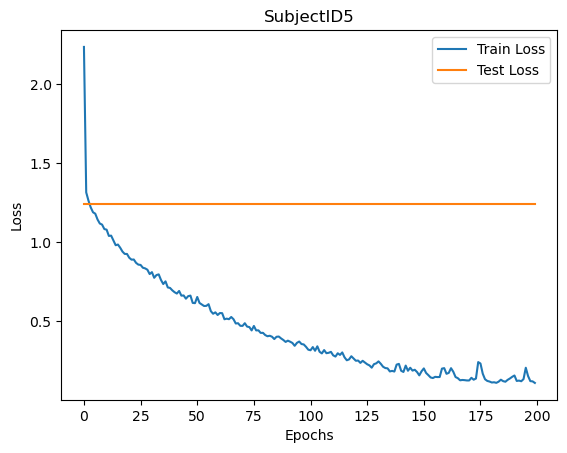

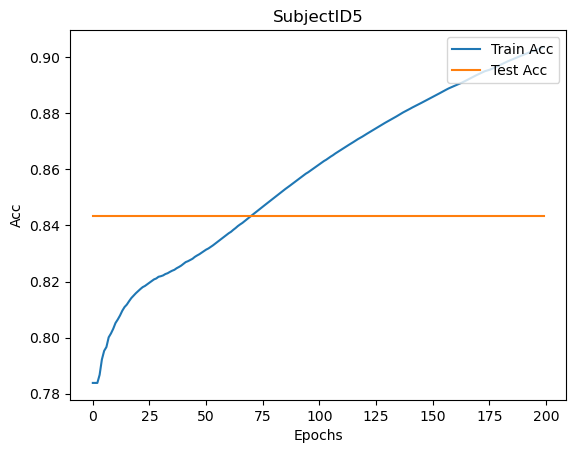


Subject 7
| epoch   0 | 0.2395 s/epoch | train loss 2.1158
| epoch   1 | 0.2401 s/epoch | train loss 1.2542
| epoch   2 | 0.2395 s/epoch | train loss 1.1965
| epoch   3 | 0.2393 s/epoch | train loss 1.1539
| epoch   4 | 0.2409 s/epoch | train loss 1.1295
| epoch   5 | 0.2393 s/epoch | train loss 1.0858
| epoch   6 | 0.2394 s/epoch | train loss 1.0488
| epoch   7 | 0.2387 s/epoch | train loss 1.0393
| epoch   8 | 0.2404 s/epoch | train loss 0.9798
| epoch   9 | 0.2391 s/epoch | train loss 0.9676
| epoch  10 | 0.2389 s/epoch | train loss 0.9284
| epoch  11 | 0.2401 s/epoch | train loss 0.9195
| epoch  12 | 0.2384 s/epoch | train loss 0.9128
| epoch  13 | 0.2405 s/epoch | train loss 0.8938
| epoch  14 | 0.2381 s/epoch | train loss 0.8882
| epoch  15 | 0.2401 s/epoch | train loss 0.8616
| epoch  16 | 0.2402 s/epoch | train loss 0.8562
| epoch  17 | 0.2392 s/epoch | train loss 0.8695
| epoch  18 | 0.2391 s/epoch | train loss 0.8143
| epoch  19 | 0.2390 s/epoch | train loss 0.8170
| epoch  

| epoch 167 | 0.2391 s/epoch | train loss 0.1102
| epoch 168 | 0.2394 s/epoch | train loss 0.1109
| epoch 169 | 0.2393 s/epoch | train loss 0.1250
| epoch 170 | 0.2412 s/epoch | train loss 0.2002
| epoch 171 | 0.2379 s/epoch | train loss 0.1630
| epoch 172 | 0.2388 s/epoch | train loss 0.1322
| epoch 173 | 0.2405 s/epoch | train loss 0.1331
| epoch 174 | 0.2399 s/epoch | train loss 0.1531
| epoch 175 | 0.2399 s/epoch | train loss 0.1449
| epoch 176 | 0.2385 s/epoch | train loss 0.1339
| epoch 177 | 0.2403 s/epoch | train loss 0.1194
| epoch 178 | 0.2394 s/epoch | train loss 0.1812
| epoch 179 | 0.2382 s/epoch | train loss 0.2102
| epoch 180 | 0.2388 s/epoch | train loss 0.1265
| epoch 181 | 0.2403 s/epoch | train loss 0.1136
| epoch 182 | 0.2385 s/epoch | train loss 0.1050
| epoch 183 | 0.2407 s/epoch | train loss 0.1035
| epoch 184 | 0.2385 s/epoch | train loss 0.0999
| epoch 185 | 0.2383 s/epoch | train loss 0.0969
| epoch 186 | 0.2391 s/epoch | train loss 0.0980
| epoch 187 | 0.2410

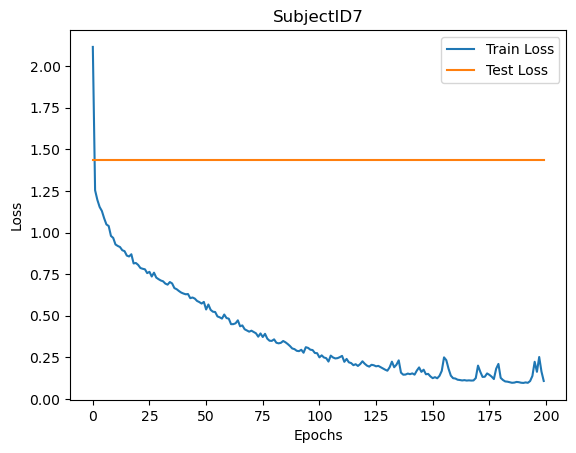

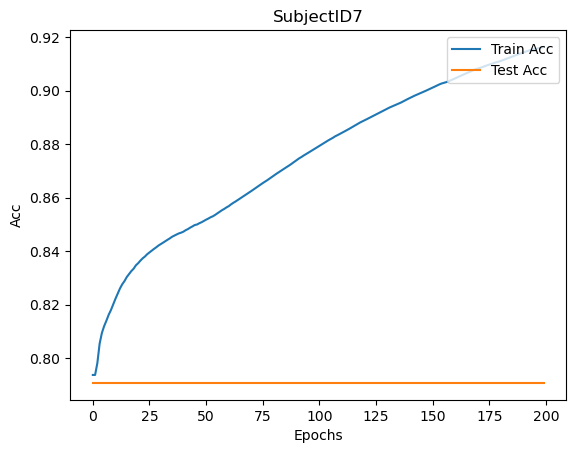


Subject 8
| epoch   0 | 0.2499 s/epoch | train loss 2.0531
| epoch   1 | 0.2491 s/epoch | train loss 1.3369
| epoch   2 | 0.2499 s/epoch | train loss 1.2792
| epoch   3 | 0.2515 s/epoch | train loss 1.2468
| epoch   4 | 0.2494 s/epoch | train loss 1.2091
| epoch   5 | 0.2498 s/epoch | train loss 1.1453
| epoch   6 | 0.2507 s/epoch | train loss 1.1268
| epoch   7 | 0.2501 s/epoch | train loss 1.1019
| epoch   8 | 0.2252 s/epoch | train loss 1.0660
| epoch   9 | 0.2518 s/epoch | train loss 1.0374
| epoch  10 | 0.2506 s/epoch | train loss 1.0038
| epoch  11 | 0.2519 s/epoch | train loss 0.9850
| epoch  12 | 0.2535 s/epoch | train loss 0.9844
| epoch  13 | 0.2523 s/epoch | train loss 0.9593
| epoch  14 | 0.2524 s/epoch | train loss 0.9497
| epoch  15 | 0.2503 s/epoch | train loss 0.9160
| epoch  16 | 0.2524 s/epoch | train loss 0.9280
| epoch  17 | 0.2523 s/epoch | train loss 0.9012
| epoch  18 | 0.2521 s/epoch | train loss 0.8860
| epoch  19 | 0.2523 s/epoch | train loss 0.8922
| epoch  

| epoch 167 | 0.2904 s/epoch | train loss 0.1030
| epoch 168 | 0.2894 s/epoch | train loss 0.1004
| epoch 169 | 0.2897 s/epoch | train loss 0.1007
| epoch 170 | 0.2905 s/epoch | train loss 0.1031
| epoch 171 | 0.2909 s/epoch | train loss 0.1005
| epoch 172 | 0.2902 s/epoch | train loss 0.0995
| epoch 173 | 0.2924 s/epoch | train loss 0.1034
| epoch 174 | 0.2921 s/epoch | train loss 0.1010
| epoch 175 | 0.2939 s/epoch | train loss 0.1024
| epoch 176 | 0.2928 s/epoch | train loss 0.1673
| epoch 177 | 0.2921 s/epoch | train loss 0.2410
| epoch 178 | 0.2982 s/epoch | train loss 0.1955
| epoch 179 | 0.2912 s/epoch | train loss 0.1444
| epoch 180 | 0.2904 s/epoch | train loss 0.1180
| epoch 181 | 0.2970 s/epoch | train loss 0.1098
| epoch 182 | 0.2935 s/epoch | train loss 0.0984
| epoch 183 | 0.2924 s/epoch | train loss 0.1132
| epoch 184 | 0.2936 s/epoch | train loss 0.1019
| epoch 185 | 0.6377 s/epoch | train loss 0.0968
| epoch 186 | 0.2886 s/epoch | train loss 0.0951
| epoch 187 | 0.2877

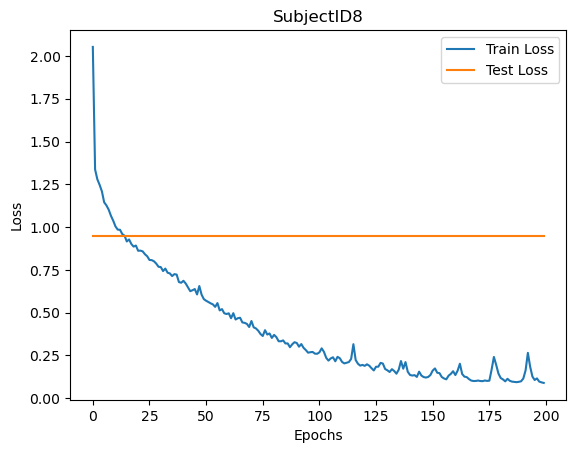

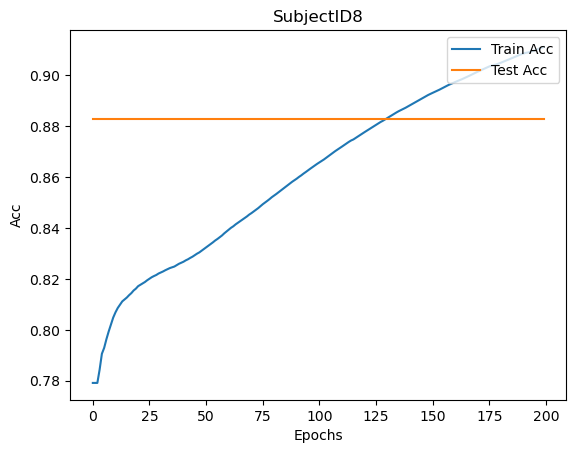


Subject 9
| epoch   0 | 0.2847 s/epoch | train loss 2.1269
| epoch   1 | 0.2836 s/epoch | train loss 1.3538
| epoch   2 | 0.2850 s/epoch | train loss 1.2963
| epoch   3 | 0.2830 s/epoch | train loss 1.2625
| epoch   4 | 0.2871 s/epoch | train loss 1.2539
| epoch   5 | 0.2844 s/epoch | train loss 1.2347
| epoch   6 | 0.2853 s/epoch | train loss 1.1629
| epoch   7 | 0.2868 s/epoch | train loss 1.1216
| epoch   8 | 0.2834 s/epoch | train loss 1.0976
| epoch   9 | 0.2827 s/epoch | train loss 1.0681
| epoch  10 | 0.2821 s/epoch | train loss 1.0158
| epoch  11 | 0.2848 s/epoch | train loss 1.0486
| epoch  12 | 0.2848 s/epoch | train loss 0.9810
| epoch  13 | 0.2853 s/epoch | train loss 0.9525
| epoch  14 | 0.2846 s/epoch | train loss 0.9526
| epoch  15 | 0.2841 s/epoch | train loss 0.9428
| epoch  16 | 0.2854 s/epoch | train loss 0.9374
| epoch  17 | 0.2875 s/epoch | train loss 0.9001
| epoch  18 | 0.2866 s/epoch | train loss 0.9016
| epoch  19 | 0.2831 s/epoch | train loss 0.8826
| epoch  

| epoch 167 | 0.2553 s/epoch | train loss 0.2150
| epoch 168 | 0.2569 s/epoch | train loss 0.2466
| epoch 169 | 0.2557 s/epoch | train loss 0.1768
| epoch 170 | 0.2561 s/epoch | train loss 0.1664
| epoch 171 | 0.2579 s/epoch | train loss 0.1550
| epoch 172 | 0.2562 s/epoch | train loss 0.1206
| epoch 173 | 0.2580 s/epoch | train loss 0.1087
| epoch 174 | 0.2550 s/epoch | train loss 0.1080
| epoch 175 | 0.2577 s/epoch | train loss 0.1043
| epoch 176 | 0.2609 s/epoch | train loss 0.1023
| epoch 177 | 0.2626 s/epoch | train loss 0.1198
| epoch 178 | 0.2602 s/epoch | train loss 0.1157
| epoch 179 | 0.2610 s/epoch | train loss 0.1047
| epoch 180 | 0.2627 s/epoch | train loss 0.1069
| epoch 181 | 0.2601 s/epoch | train loss 0.1061
| epoch 182 | 0.2555 s/epoch | train loss 0.1117
| epoch 183 | 0.2559 s/epoch | train loss 0.1118
| epoch 184 | 0.2584 s/epoch | train loss 0.1467
| epoch 185 | 0.2585 s/epoch | train loss 0.2156
| epoch 186 | 0.2596 s/epoch | train loss 0.1376
| epoch 187 | 0.2572

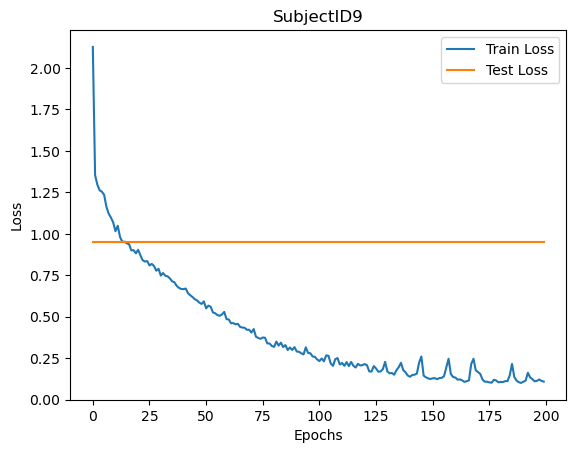

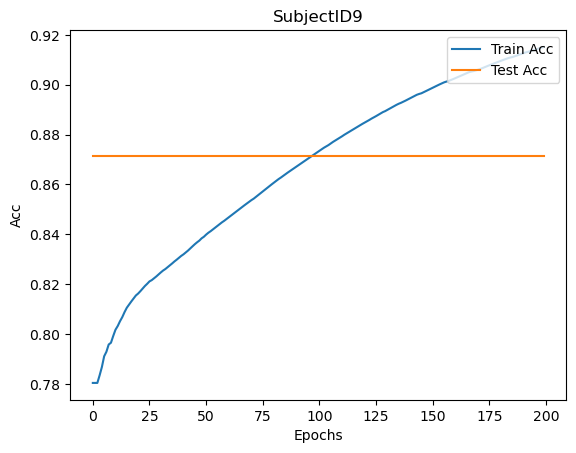


Subject 10
| epoch   0 | 0.2670 s/epoch | train loss 2.2097
| epoch   1 | 0.2683 s/epoch | train loss 1.3573
| epoch   2 | 0.2673 s/epoch | train loss 1.2997
| epoch   3 | 0.2691 s/epoch | train loss 1.2399
| epoch   4 | 0.2679 s/epoch | train loss 1.2097
| epoch   5 | 0.2714 s/epoch | train loss 1.2248
| epoch   6 | 0.2767 s/epoch | train loss 1.1918
| epoch   7 | 0.2729 s/epoch | train loss 1.1504
| epoch   8 | 0.2718 s/epoch | train loss 1.1295
| epoch   9 | 0.2694 s/epoch | train loss 1.1034
| epoch  10 | 0.2661 s/epoch | train loss 1.1107
| epoch  11 | 0.2651 s/epoch | train loss 1.0593
| epoch  12 | 0.2643 s/epoch | train loss 1.0419
| epoch  13 | 0.2658 s/epoch | train loss 1.0043
| epoch  14 | 0.2675 s/epoch | train loss 1.0119
| epoch  15 | 0.2655 s/epoch | train loss 0.9724
| epoch  16 | 0.2644 s/epoch | train loss 0.9726
| epoch  17 | 0.2668 s/epoch | train loss 0.9437
| epoch  18 | 0.2656 s/epoch | train loss 0.9610
| epoch  19 | 0.2641 s/epoch | train loss 0.9414
| epoch 

| epoch 167 | 0.2653 s/epoch | train loss 0.1308
| epoch 168 | 0.2633 s/epoch | train loss 0.1364
| epoch 169 | 0.2641 s/epoch | train loss 0.1465
| epoch 170 | 0.2640 s/epoch | train loss 0.1991
| epoch 171 | 0.2646 s/epoch | train loss 0.1554
| epoch 172 | 0.2644 s/epoch | train loss 0.1260
| epoch 173 | 0.2647 s/epoch | train loss 0.1233
| epoch 174 | 0.2640 s/epoch | train loss 0.1157
| epoch 175 | 0.2653 s/epoch | train loss 0.1193
| epoch 176 | 0.2641 s/epoch | train loss 0.1449
| epoch 177 | 0.2639 s/epoch | train loss 0.1880
| epoch 178 | 0.2646 s/epoch | train loss 0.1646
| epoch 179 | 0.2650 s/epoch | train loss 0.1570
| epoch 180 | 0.2638 s/epoch | train loss 0.1837
| epoch 181 | 0.2633 s/epoch | train loss 0.1259
| epoch 182 | 0.2648 s/epoch | train loss 0.1066
| epoch 183 | 0.2637 s/epoch | train loss 0.1020
| epoch 184 | 0.2644 s/epoch | train loss 0.0975
| epoch 185 | 0.2633 s/epoch | train loss 0.0966
| epoch 186 | 0.2637 s/epoch | train loss 0.0962
| epoch 187 | 0.2642

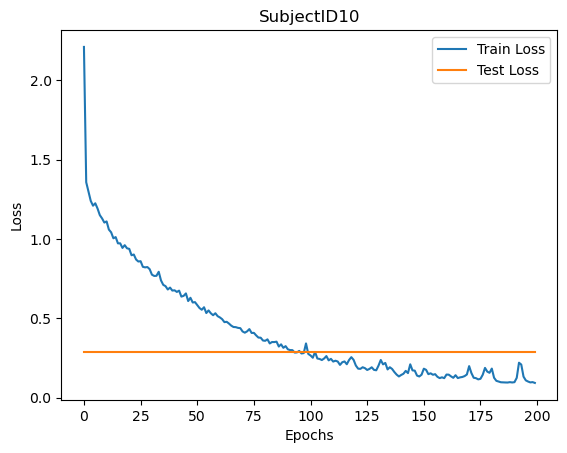

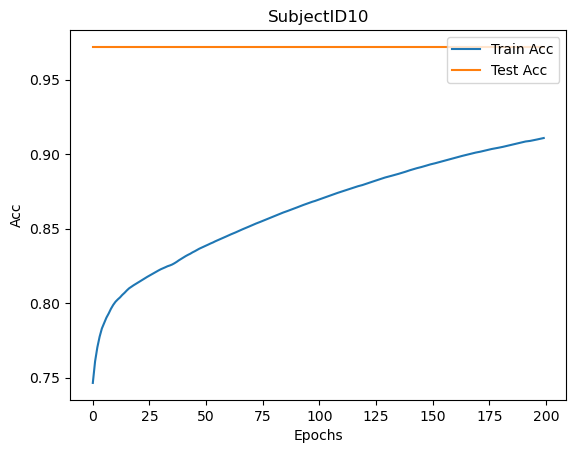


Subject 11
| epoch   0 | 0.2602 s/epoch | train loss 2.0133
| epoch   1 | 0.2604 s/epoch | train loss 1.3290
| epoch   2 | 0.2604 s/epoch | train loss 1.2938
| epoch   3 | 0.2625 s/epoch | train loss 1.2459
| epoch   4 | 0.2623 s/epoch | train loss 1.2278
| epoch   5 | 0.2598 s/epoch | train loss 1.1845
| epoch   6 | 0.2603 s/epoch | train loss 1.1677
| epoch   7 | 0.2594 s/epoch | train loss 1.1462
| epoch   8 | 0.2591 s/epoch | train loss 1.0924
| epoch   9 | 0.2597 s/epoch | train loss 1.0760
| epoch  10 | 0.2603 s/epoch | train loss 1.0559
| epoch  11 | 0.2627 s/epoch | train loss 1.0458
| epoch  12 | 0.2603 s/epoch | train loss 1.0153
| epoch  13 | 0.2604 s/epoch | train loss 1.0016
| epoch  14 | 0.2615 s/epoch | train loss 0.9728
| epoch  15 | 0.2612 s/epoch | train loss 0.9565
| epoch  16 | 0.2616 s/epoch | train loss 0.9220
| epoch  17 | 0.2611 s/epoch | train loss 0.9253
| epoch  18 | 0.2621 s/epoch | train loss 0.8979
| epoch  19 | 0.2582 s/epoch | train loss 0.8965
| epoch 

| epoch 167 | 0.1921 s/epoch | train loss 0.1314
| epoch 168 | 0.1921 s/epoch | train loss 0.1186
| epoch 169 | 0.1914 s/epoch | train loss 0.1151
| epoch 170 | 0.1909 s/epoch | train loss 0.1181
| epoch 171 | 0.1931 s/epoch | train loss 0.1115
| epoch 172 | 0.1923 s/epoch | train loss 0.1104
| epoch 173 | 0.1930 s/epoch | train loss 0.1137
| epoch 174 | 0.1918 s/epoch | train loss 0.1133
| epoch 175 | 0.1913 s/epoch | train loss 0.1096
| epoch 176 | 0.1925 s/epoch | train loss 0.1077
| epoch 177 | 0.1930 s/epoch | train loss 0.1135
| epoch 178 | 0.1920 s/epoch | train loss 0.1195
| epoch 179 | 0.1928 s/epoch | train loss 0.1122
| epoch 180 | 0.1914 s/epoch | train loss 0.1380
| epoch 181 | 0.1924 s/epoch | train loss 0.2565
| epoch 182 | 0.1935 s/epoch | train loss 0.1454
| epoch 183 | 0.1919 s/epoch | train loss 0.1376
| epoch 184 | 0.1931 s/epoch | train loss 0.1130
| epoch 185 | 0.1926 s/epoch | train loss 0.1092
| epoch 186 | 0.1919 s/epoch | train loss 0.1010
| epoch 187 | 0.1938

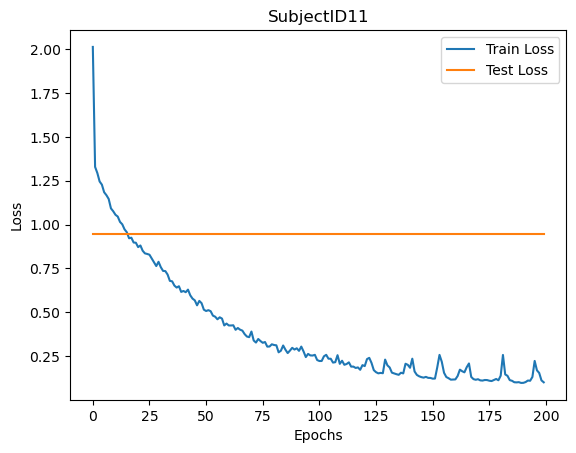

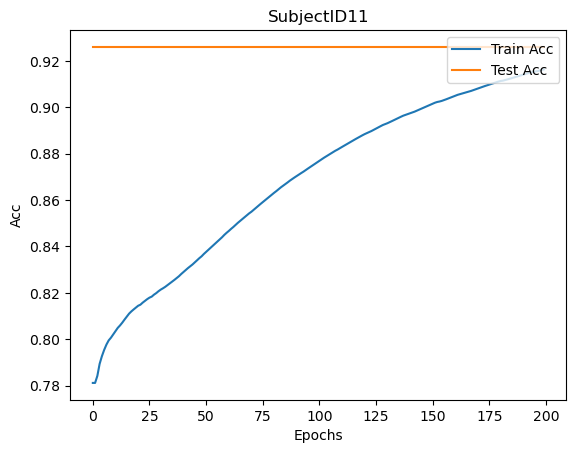


Subject 12
| epoch   0 | 0.1852 s/epoch | train loss 2.1281
| epoch   1 | 0.1834 s/epoch | train loss 1.3089
| epoch   2 | 0.1817 s/epoch | train loss 1.2596
| epoch   3 | 0.1850 s/epoch | train loss 1.2041
| epoch   4 | 0.1836 s/epoch | train loss 1.1892
| epoch   5 | 0.1835 s/epoch | train loss 1.1862
| epoch   6 | 0.1835 s/epoch | train loss 1.1060
| epoch   7 | 0.1828 s/epoch | train loss 1.0995
| epoch   8 | 0.1832 s/epoch | train loss 1.0909
| epoch   9 | 0.1831 s/epoch | train loss 1.0554
| epoch  10 | 0.1822 s/epoch | train loss 1.0840
| epoch  11 | 0.1842 s/epoch | train loss 1.0515
| epoch  12 | 0.1834 s/epoch | train loss 1.0523
| epoch  13 | 0.1824 s/epoch | train loss 1.0243
| epoch  14 | 0.1839 s/epoch | train loss 1.0171
| epoch  15 | 0.1826 s/epoch | train loss 0.9881
| epoch  16 | 0.1830 s/epoch | train loss 0.9724
| epoch  17 | 0.1834 s/epoch | train loss 0.9342
| epoch  18 | 0.1843 s/epoch | train loss 0.9292
| epoch  19 | 0.1829 s/epoch | train loss 0.9069
| epoch 

| epoch 167 | 0.1888 s/epoch | train loss 0.1131
| epoch 168 | 0.1928 s/epoch | train loss 0.1156
| epoch 169 | 0.1899 s/epoch | train loss 0.1090
| epoch 170 | 0.1883 s/epoch | train loss 0.1053
| epoch 171 | 0.1879 s/epoch | train loss 0.1076
| epoch 172 | 0.1842 s/epoch | train loss 0.1037
| epoch 173 | 0.1834 s/epoch | train loss 0.1101
| epoch 174 | 0.1840 s/epoch | train loss 0.1406
| epoch 175 | 0.1828 s/epoch | train loss 0.1442
| epoch 176 | 0.1839 s/epoch | train loss 0.1264
| epoch 177 | 0.1850 s/epoch | train loss 0.1662
| epoch 178 | 0.1858 s/epoch | train loss 0.2546
| epoch 179 | 0.1877 s/epoch | train loss 0.1353
| epoch 180 | 0.1878 s/epoch | train loss 0.1121
| epoch 181 | 0.1892 s/epoch | train loss 0.1126
| epoch 182 | 0.1890 s/epoch | train loss 0.1049
| epoch 183 | 0.1864 s/epoch | train loss 0.0996
| epoch 184 | 0.1889 s/epoch | train loss 0.1129
| epoch 185 | 0.2037 s/epoch | train loss 0.1198
| epoch 186 | 0.2498 s/epoch | train loss 0.1199
| epoch 187 | 0.2509

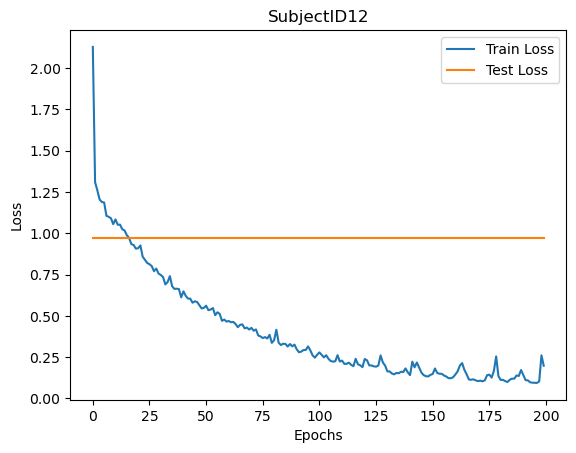

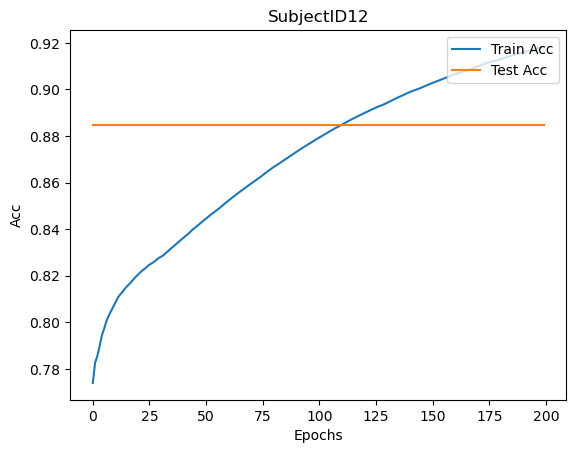


Subject 13
| epoch   0 | 0.2510 s/epoch | train loss 2.2286
| epoch   1 | 0.2524 s/epoch | train loss 1.3189
| epoch   2 | 0.2509 s/epoch | train loss 1.2611
| epoch   3 | 0.2524 s/epoch | train loss 1.2070
| epoch   4 | 0.2505 s/epoch | train loss 1.2032
| epoch   5 | 0.2506 s/epoch | train loss 1.1676
| epoch   6 | 0.2521 s/epoch | train loss 1.1416
| epoch   7 | 0.2504 s/epoch | train loss 1.1287
| epoch   8 | 0.2526 s/epoch | train loss 1.1095
| epoch   9 | 0.2494 s/epoch | train loss 1.0793
| epoch  10 | 0.2535 s/epoch | train loss 1.0690
| epoch  11 | 0.2559 s/epoch | train loss 1.0249
| epoch  12 | 0.2497 s/epoch | train loss 1.0740
| epoch  13 | 0.2511 s/epoch | train loss 0.9902
| epoch  14 | 0.2525 s/epoch | train loss 0.9713
| epoch  15 | 0.2531 s/epoch | train loss 0.9803
| epoch  16 | 0.2490 s/epoch | train loss 0.9805
| epoch  17 | 0.2460 s/epoch | train loss 0.9316
| epoch  18 | 0.2458 s/epoch | train loss 0.9128
| epoch  19 | 0.2475 s/epoch | train loss 0.9191
| epoch 

| epoch 167 | 0.2444 s/epoch | train loss 0.1443
| epoch 168 | 0.2441 s/epoch | train loss 0.1444
| epoch 169 | 0.2476 s/epoch | train loss 0.1463
| epoch 170 | 0.2454 s/epoch | train loss 0.1464
| epoch 171 | 0.2408 s/epoch | train loss 0.1326
| epoch 172 | 0.2393 s/epoch | train loss 0.1250
| epoch 173 | 0.2389 s/epoch | train loss 0.1163
| epoch 174 | 0.2402 s/epoch | train loss 0.1120
| epoch 175 | 0.2373 s/epoch | train loss 0.1123
| epoch 176 | 0.2375 s/epoch | train loss 0.1119
| epoch 177 | 0.2391 s/epoch | train loss 0.1239
| epoch 178 | 0.2395 s/epoch | train loss 0.1606
| epoch 179 | 0.2402 s/epoch | train loss 0.1879
| epoch 180 | 0.2377 s/epoch | train loss 0.2569
| epoch 181 | 0.2396 s/epoch | train loss 0.1822
| epoch 182 | 0.2386 s/epoch | train loss 0.1323
| epoch 183 | 0.2388 s/epoch | train loss 0.1233
| epoch 184 | 0.2398 s/epoch | train loss 0.1261
| epoch 185 | 0.2398 s/epoch | train loss 0.1125
| epoch 186 | 0.2386 s/epoch | train loss 0.1052
| epoch 187 | 0.2410

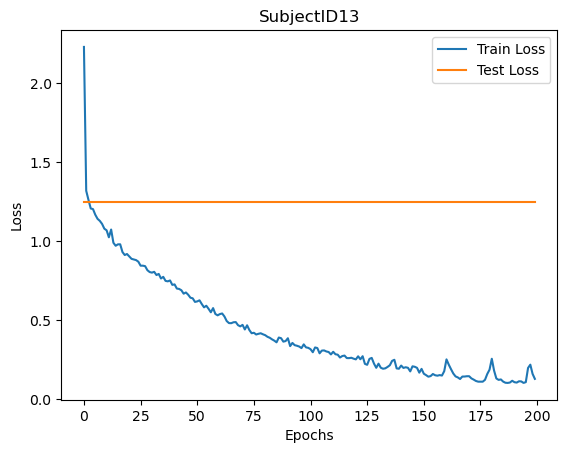

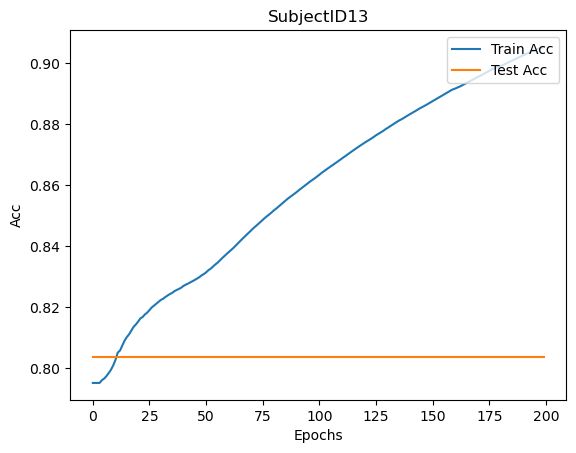


Subject 14
| epoch   0 | 0.2467 s/epoch | train loss 2.4019
| epoch   1 | 0.2489 s/epoch | train loss 1.3939
| epoch   2 | 0.2472 s/epoch | train loss 1.3395
| epoch   3 | 0.2473 s/epoch | train loss 1.2621
| epoch   4 | 0.2482 s/epoch | train loss 1.2407
| epoch   5 | 0.2491 s/epoch | train loss 1.2360
| epoch   6 | 0.2490 s/epoch | train loss 1.1904
| epoch   7 | 0.2487 s/epoch | train loss 1.1850
| epoch   8 | 0.2464 s/epoch | train loss 1.1415
| epoch   9 | 0.2492 s/epoch | train loss 1.0865
| epoch  10 | 0.2487 s/epoch | train loss 1.1211
| epoch  11 | 0.2490 s/epoch | train loss 1.1283
| epoch  12 | 0.2508 s/epoch | train loss 1.0548
| epoch  13 | 0.2556 s/epoch | train loss 1.0368
| epoch  14 | 0.2533 s/epoch | train loss 1.0041
| epoch  15 | 0.2541 s/epoch | train loss 1.0220
| epoch  16 | 0.2541 s/epoch | train loss 1.0026
| epoch  17 | 0.2536 s/epoch | train loss 0.9668
| epoch  18 | 0.2559 s/epoch | train loss 0.9507
| epoch  19 | 0.2533 s/epoch | train loss 0.9627
| epoch 

| epoch 167 | 0.2546 s/epoch | train loss 0.1593
| epoch 168 | 0.2557 s/epoch | train loss 0.1632
| epoch 169 | 0.2545 s/epoch | train loss 0.1544
| epoch 170 | 0.2538 s/epoch | train loss 0.1501
| epoch 171 | 0.2553 s/epoch | train loss 0.1410
| epoch 172 | 0.2550 s/epoch | train loss 0.1355
| epoch 173 | 0.2547 s/epoch | train loss 0.2366
| epoch 174 | 0.2534 s/epoch | train loss 0.2534
| epoch 175 | 0.2543 s/epoch | train loss 0.1997
| epoch 176 | 0.2554 s/epoch | train loss 0.1553
| epoch 177 | 0.2539 s/epoch | train loss 0.1376
| epoch 178 | 0.2546 s/epoch | train loss 0.1318
| epoch 179 | 0.2551 s/epoch | train loss 0.1316
| epoch 180 | 0.2545 s/epoch | train loss 0.1956
| epoch 181 | 0.2541 s/epoch | train loss 0.1462
| epoch 182 | 0.2544 s/epoch | train loss 0.2188
| epoch 183 | 0.2544 s/epoch | train loss 0.2059
| epoch 184 | 0.2549 s/epoch | train loss 0.1494
| epoch 185 | 0.2546 s/epoch | train loss 0.1329
| epoch 186 | 0.2540 s/epoch | train loss 0.1304
| epoch 187 | 0.2545

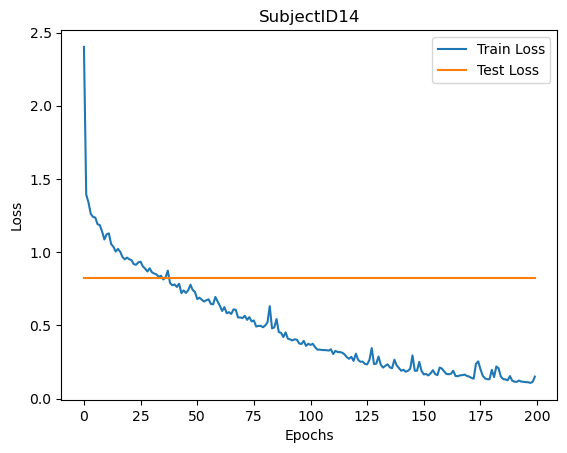

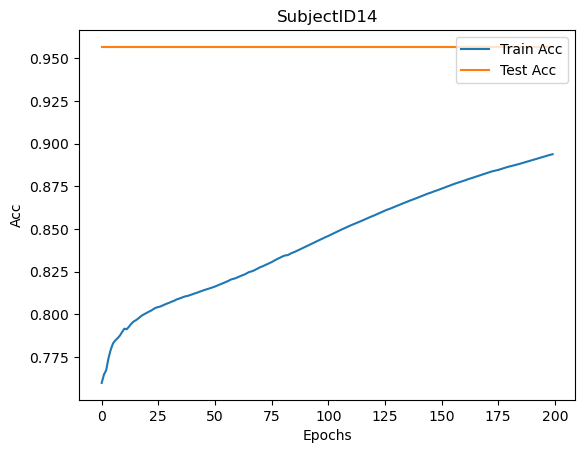


Subject 15
| epoch   0 | 0.2633 s/epoch | train loss 2.1926
| epoch   1 | 0.2610 s/epoch | train loss 1.3369
| epoch   2 | 0.2588 s/epoch | train loss 1.2597
| epoch   3 | 0.2599 s/epoch | train loss 1.2407
| epoch   4 | 0.2592 s/epoch | train loss 1.2137
| epoch   5 | 0.2592 s/epoch | train loss 1.1929
| epoch   6 | 0.2576 s/epoch | train loss 1.1693
| epoch   7 | 0.2575 s/epoch | train loss 1.1249
| epoch   8 | 0.2601 s/epoch | train loss 1.1303
| epoch   9 | 0.2583 s/epoch | train loss 1.0761
| epoch  10 | 0.2590 s/epoch | train loss 1.0454
| epoch  11 | 0.2570 s/epoch | train loss 1.0406
| epoch  12 | 0.2627 s/epoch | train loss 1.0205
| epoch  13 | 0.2586 s/epoch | train loss 0.9832
| epoch  14 | 0.2593 s/epoch | train loss 0.9658
| epoch  15 | 0.2594 s/epoch | train loss 0.9482
| epoch  16 | 0.2589 s/epoch | train loss 0.9371
| epoch  17 | 0.2603 s/epoch | train loss 0.9262
| epoch  18 | 0.2597 s/epoch | train loss 0.9059
| epoch  19 | 0.2582 s/epoch | train loss 0.8801
| epoch 

| epoch 167 | 0.1975 s/epoch | train loss 0.0933
| epoch 168 | 0.1979 s/epoch | train loss 0.0963
| epoch 169 | 0.1981 s/epoch | train loss 0.0962
| epoch 170 | 0.1970 s/epoch | train loss 0.1093
| epoch 171 | 0.1984 s/epoch | train loss 0.1685
| epoch 172 | 0.2000 s/epoch | train loss 0.1558
| epoch 173 | 0.1990 s/epoch | train loss 0.1635
| epoch 174 | 0.1987 s/epoch | train loss 0.1444
| epoch 175 | 0.1983 s/epoch | train loss 0.1388
| epoch 176 | 0.1994 s/epoch | train loss 0.1458
| epoch 177 | 0.1985 s/epoch | train loss 0.1220
| epoch 178 | 0.1983 s/epoch | train loss 0.0997
| epoch 179 | 0.1986 s/epoch | train loss 0.0893
| epoch 180 | 0.1988 s/epoch | train loss 0.0876
| epoch 181 | 0.1983 s/epoch | train loss 0.0897
| epoch 182 | 0.1988 s/epoch | train loss 0.0879
| epoch 183 | 0.1988 s/epoch | train loss 0.0841
| epoch 184 | 0.1985 s/epoch | train loss 0.0851
| epoch 185 | 0.1973 s/epoch | train loss 0.0840
| epoch 186 | 0.1980 s/epoch | train loss 0.0825
| epoch 187 | 0.1984

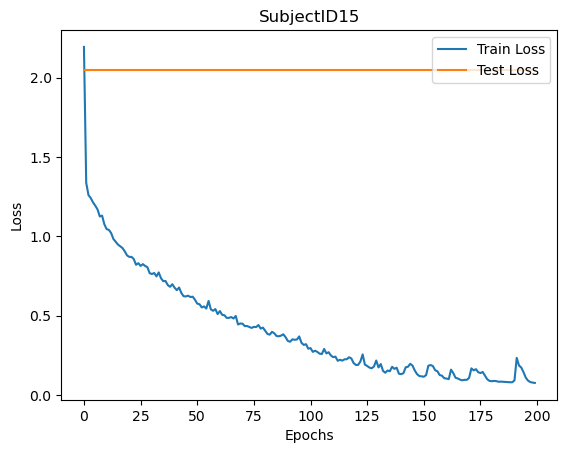

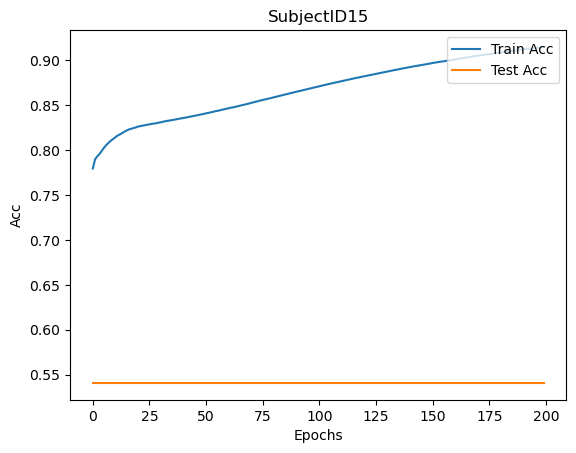

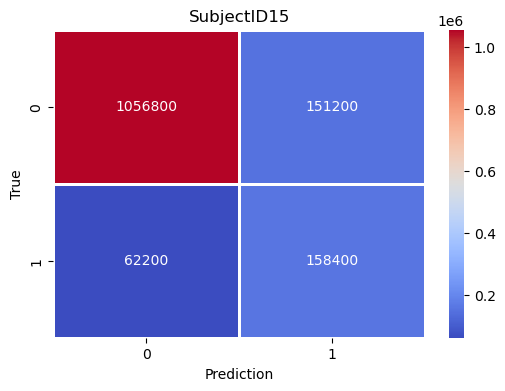

Distillation_Student(CNN)_Acc: 0.8506229875402492
Distillation_Student(CNN)_Rec: 0.7180417044424298
Distillation_Student(CNN)_Pre: 0.5116279069767442
Distillation_Student(CNN)_F1: 0.5975103734439835


<Figure size 640x480 with 0 Axes>

In [12]:

teacher_student_train_preds = []
teacher_student_train_gt = []

for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode

    model_teacher_student = Net_Teacher_Student(config).to(device) 
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)

show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_Student(CNN)_Acc:",teacher_Student_eval_table[0])
print("Distillation_Student(CNN)_Rec:",teacher_Student_eval_table[1])
print("Distillation_Student(CNN)_Pre:",teacher_Student_eval_table[2])
print("Distillation_Student(CNN)_F1:",teacher_Student_eval_table[3])

In [13]:
# print("Teacher(RestNet18)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(RestNet18)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(RestNet18)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(RestNet18)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(CNN)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(CNN)_Rec:",sum(Recall_student)/11)
# print("Original_Student(CNN)_Pre:",sum(Precision_student)/11)
# print("Original_Student(CNN)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(CNN)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(CNN)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(CNN)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(CNN)_F1:",sum(F1score_teacher_student)/11)

dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))
flops_student, params_student = profile(model_student,(dummy_input,))
print('flops_student: %.3f M, params_student: %.3f M' % (flops_student / 1000000.0, params_student / 1000000.0))
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('flops_teacher_student: %.3f M, params_teacher_student: %.3f M' % (flops_teacher_student / 1000000.0, params_teacher_student / 1000000.0))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


flops_teacher: 6823.395 M, params_teachar: 58.139 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
flops_student: 10.412 M, params_student: 0.120 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_o